# Detección de Intrusiones y Análisis de Anomalías en Tráfico de Red mediante Técnicas Estadísticas

**Universidad de La Habana, MATCOM**  
**Curso:** Estadística 2025-2026  
**Proyecto Final:** Análisis Estadístico Aplicado a Seguridad Informática

---

## 1. Introducción

### 1.1 Contexto y Motivación

La seguridad informática es un pilar fundamental de la infraestructura tecnológica moderna. Los Sistemas de Detección de Intrusiones (IDS) tradicionales, basados en firmas conocidas, presentan limitaciones significativas frente a ataques emergentes (zero-day attacks). 

Este proyecto propone un **enfoque complementario basado en análisis estadístico del comportamiento del tráfico de red**, permitiendo identificar patrones anómalos sin depender exclusivamente de firmas catalogadas previamente. Esta aproximación resulta especialmente relevante en entornos dinámicos donde los ataques evolucionan constantemente.

---

### 1.2 Dataset: NSL-KDD

#### Descripción General

El dataset **NSL-KDD** fue desarrollado por investigadores del Canadian Institute for Cybersecurity (Universidad de New Brunswick) como versión corregida del benchmark KDD Cup 1999. Resuelve problemas críticos del dataset original (78% registros duplicados, sesgo de distribución) mediante eliminación de redundancias y balanceo mejorado de clases.

**Fuente:** [Kaggle - NSL-KDD](https://www.kaggle.com/datasets/hassan06/nslkdd) | Tavallaee et al. (2009)

**Dimensiones del dataset:**
- **Conjunto de entrenamiento (20%):** 25,192 observaciones
- **Conjunto de prueba:** 22,544 observaciones  
- **Variables:** 41 predictoras + 2 metadatos (`attack_type`, `difficulty_level`)

---

#### Categorías de Ataque

El dataset clasifica el tráfico de red en **5 categorías principales**:

| Categoría | Descripción | Ejemplos |
|-----------|-------------|----------|
| **Normal** | Tráfico legítimo | - |
| **DoS** | Denegación de servicio por sobrecarga | neptune, smurf, teardrop |
| **Probe** | Escaneo de vulnerabilidades | portsweep, nmap, satan |
| **R2L** | Acceso remoto no autorizado | guess_passwd, ftp_write |
| **U2R** | Escalada de privilegios | buffer_overflow, rootkit |

---

#### Estructura de Variables

Las 41 variables predictoras se agrupan en **4 categorías**:

- **Básicas (9):** Derivadas de cabeceras TCP/IP → *duration, protocol_type, service, flag, src_bytes, dst_bytes*
- **De contenido (13):** Información del payload → *num_failed_logins, root_shell, num_file_creations*
- **De tráfico temporal (9):** Ventanas de 2 segundos → *count, serror_rate, same_srv_rate*
- **Basadas en host (10):** Últimas 100 conexiones → *dst_host_count, dst_host_same_srv_rate*


### 1.3 Carga y Preparación Inicial

#### 1.3.1 Configuración del Entorno

In [187]:
# Importación de librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sklearn as sk
import scipy
import os
import statsmodels
import scikit_posthocs
# Configuración de visualizaciones
warnings.filterwarnings('ignore')
%matplotlib inline

# Estilo global para mantener consistencia en todas las visualizaciones
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

# Paleta de colores consistente para categorías de ataque
# Se utilizará en todas las visualizaciones del proyecto
attack_colors = {
    'Normal': '#2ecc71',    # Verde - Tráfico legítimo
    'DoS': '#e74c3c',       # Rojo - Ataques de denegación de servicio
    'Probe': '#f39c12',     # Naranja - Ataques de reconocimiento
    'R2L': '#9b59b6',       # Morado - Acceso remoto no autorizado
    'U2R': '#34495e'        # Gris oscuro - Escalada de privilegios
}

print("✅ Librerías importadas y configuración de visualización establecida. ")

✅ Librerías importadas y configuración de visualización establecida. 


#### 1.3.2 Carga de Archivos y Verificación de Estructura

In [188]:
# Definir los nombres de las columnas (43 columnas en total)
# Fuente: Documentación oficial NSL-KDD (Universidad de New Brunswick)
col_names = [
    # Variables básicas derivadas de cabeceras TCP/IP (9)
    "duration",           # Duración de la conexión en segundos
    "protocol_type",      # Protocolo: TCP, UDP, ICMP
    "service",            # Servicio de red destino (http, ftp, smtp, etc.)
    "flag",               # Estado de la conexión (SF, S0, REJ, etc.)
    "src_bytes",          # Bytes enviados desde origen a destino
    "dst_bytes",          # Bytes enviados desde destino a origen
    "land",               # 1 si origen y destino son iguales (ataque LAND)
    "wrong_fragment",     # Número de fragmentos incorrectos
    "urgent",             # Número de paquetes urgentes
    
    # Variables de contenido de la conexión (13)
    "hot",                # Número de indicadores "hot" (acceso a archivos críticos)
    "num_failed_logins",  # Número de intentos fallidos de login
    "logged_in",          # 1 si login exitoso
    "num_compromised",    # Número de condiciones "comprometidas"
    "root_shell",         # 1 si se obtuvo acceso root
    "su_attempted",       # 1 si comando "su root" fue intentado
    "num_root",           # Número de accesos root
    "num_file_creations", # Número de operaciones de creación de archivos
    "num_shells",         # Número de shells iniciados
    "num_access_files",   # Número de operaciones de acceso a archivos de control
    "num_outbound_cmds",  # Número de comandos FTP salientes (siempre 0 en dataset)
    "is_host_login",      # 1 si login es a host (no guest)
    "is_guest_login",     # 1 si login es de invitado
    
    # Variables de tráfico basadas en tiempo (ventana de 2 seg) (9)
    "count",              # Número de conexiones al mismo host en últimos 2 seg
    "srv_count",          # Número de conexiones al mismo servicio en últimos 2 seg
    "serror_rate",        # % de conexiones con errores SYN en count
    "srv_serror_rate",    # % de conexiones con errores SYN en srv_count
    "rerror_rate",        # % de conexiones con errores REJ en count
    "srv_rerror_rate",    # % de conexiones con errores REJ en srv_count
    "same_srv_rate",      # % de conexiones al mismo servicio en count
    "diff_srv_rate",      # % de conexiones a diferentes servicios en count
    "srv_diff_host_rate", # % de conexiones a diferentes hosts en srv_count
    
    # Variables de tráfico basadas en host (últimas 100 conexiones) (10)
    "dst_host_count",              # Conexiones al mismo host destino
    "dst_host_srv_count",          # Conexiones al mismo servicio en host destino
    "dst_host_same_srv_rate",      # % conexiones al mismo servicio
    "dst_host_diff_srv_rate",      # % conexiones a diferentes servicios
    "dst_host_same_src_port_rate", # % conexiones desde mismo puerto origen
    "dst_host_srv_diff_host_rate", # % conexiones desde diferentes hosts
    "dst_host_serror_rate",        # % errores SYN en dst_host_count
    "dst_host_srv_serror_rate",    # % errores SYN en dst_host_srv_count
    "dst_host_rerror_rate",        # % errores REJ en dst_host_count
    "dst_host_srv_rerror_rate",    # % errores REJ en dst_host_srv_count
    
    # Variables objetivo y metadatos (2)
    "attack_type",        # Etiqueta: tipo específico de ataque o "normal"
    "difficulty_level"    # Nivel de dificultad (0-21) asignado por los autores
]

# Cargar los datasets
# Justificación de archivos seleccionados (ver sección 1.2.3):
# - KDDTrain+_20Percent: Muestra estratificada oficial (25,192 obs)
# - KDDTest+: Conjunto completo de evaluación (22,544 obs)

# Cargar datasets
train_df = pd.read_csv('Data/KDDTrain+_20Percent.txt', names=col_names, header=None)
test_df = pd.read_csv('Data/KDDTest+.txt', names=col_names, header=None)

# Crear variable binaria para análisis de dos grupos (Normal vs. Ataque)
train_df['is_attack'] = (train_df['attack_type'] != 'normal').astype(int)
test_df['is_attack'] = (test_df['attack_type'] != 'normal').astype(int)

print(f"✅ Datos cargados:")
print(f"   Train: {train_df.shape[0]:,} × {train_df.shape[1]}")
print(f"   Test:  {test_df.shape[0]:,} × {test_df.shape[1]}")

✅ Datos cargados:
   Train: 25,192 × 44
   Test:  22,544 × 44


#### 1.3.3 Mapeo de Categorías

In [189]:
# Diccionario oficial de mapeo de ataques específicos a categorías generales
# Fuente: Documentación oficial NSL-KDD (Canadian Institute for Cybersecurity)
attack_category_mapping = {
    # Tráfico Normal
    'normal': 'Normal',
    
    # DoS (Denial of Service) - Ataques de denegación de servicio
    'back': 'DoS', 'land': 'DoS', 'neptune': 'DoS', 'pod': 'DoS',
    'smurf': 'DoS', 'teardrop': 'DoS', 'mailbomb': 'DoS', 'apache2': 'DoS',
    'processtable': 'DoS', 'udpstorm': 'DoS',
    
    # Probe (Probing/Scanning) - Ataques de reconocimiento
    'ipsweep': 'Probe', 'nmap': 'Probe', 'portsweep': 'Probe',
    'satan': 'Probe', 'mscan': 'Probe', 'saint': 'Probe',
    
    # R2L (Remote to Local) - Acceso no autorizado desde máquina remota
    'ftp_write': 'R2L', 'guess_passwd': 'R2L', 'imap': 'R2L',
    'multihop': 'R2L', 'phf': 'R2L', 'spy': 'R2L',
    'warezclient': 'R2L', 'warezmaster': 'R2L', 'sendmail': 'R2L',
    'named': 'R2L', 'snmpgetattack': 'R2L', 'snmpguess': 'R2L',
    'xlock': 'R2L', 'xsnoop': 'R2L', 'worm': 'R2L', 'xterm': 'R2L', 
    
    # U2R (User to Root) - Escalada de privilegios
    'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'perl': 'U2R',
    'rootkit': 'U2R', 'httptunnel': 'U2R', 'ps': 'U2R', 'sqlattack': 'U2R'
}

# Aplicar mapeo a ambos datasets
train_df['attack_category'] = train_df['attack_type'].map(attack_category_mapping)
test_df['attack_category'] = test_df['attack_type'].map(attack_category_mapping)

# Verificar que no hay valores sin mapear
unmapped_train = train_df['attack_category'].isna().sum()
unmapped_test = test_df['attack_category'].isna().sum()
print(f"   Valores sin mapear en train: {unmapped_train}")
print(f"   Valores sin mapear en test: {unmapped_test}")

# Crear orden categórico para visualizaciones consistentes
category_order = ['Normal', 'DoS', 'Probe', 'R2L', 'U2R']
train_df['attack_category'] = pd.Categorical(
    train_df['attack_category'], 
    categories=category_order, 
    ordered=True
)
test_df['attack_category'] = pd.Categorical(
    test_df['attack_category'], 
    categories=category_order, 
    ordered=True
)

print("\n✅ Mapeo de categorías completado exitosamente")

   Valores sin mapear en train: 0
   Valores sin mapear en test: 0

✅ Mapeo de categorías completado exitosamente


---

## 2. Análisis Exploratorio de Datos (EDA)

---

### 2.1 Inspección General de la Estructura

Esta inspección verifica supuestos básicos necesarios para análisis estadístico: ausencia de valores faltantes, coherencia de rangos y correcta codificación de variables.

In [191]:
# ============================================================================
# 2.1.1 CLASIFICACIÓN DE VARIABLES
# ============================================================================

# Identificar tipos de variables
numeric_vars = train_df.select_dtypes(include=[np.number]).columns.tolist()
categorical_vars = train_df.select_dtypes(include=['object', 'category']).columns.tolist()

# Excluir metadatos
metadata_vars = ['attack_type', 'attack_category', 'difficulty_level', 'is_attack']
numeric_vars = [v for v in numeric_vars if v not in metadata_vars]

# Separar binarias vs continuas
binary_vars = [v for v in numeric_vars if train_df[v].nunique() == 2]
continuous_vars = [v for v in numeric_vars if v not in binary_vars]

# Resumen
print(f"Variables continuas/discretas: {len(continuous_vars)}")
print(f"Variables binarias: {len(binary_vars)}")
print(f"Variables categóricas: {len(categorical_vars)}")

Variables continuas/discretas: 32
Variables binarias: 6
Variables categóricas: 5


#### 2.1.2 Verificación de Calidad de Datos

In [192]:
# ============================================================================
# VALORES FALTANTES
# ============================================================================

total_missing = train_df.isnull().sum().sum()
print(f"Valores faltantes: {total_missing}")

# ============================================================================
# VALIDACIÓN DE RANGOS
# ============================================================================

# Variables de tasa en [0,1]
rate_vars = [v for v in numeric_vars if 'rate' in v.lower()]
invalid_rates = sum((train_df[v] < 0).any() or (train_df[v] > 1).any() for v in rate_vars)
print(f"Variables de tasa fuera de rango: {invalid_rates}/{len(rate_vars)}")

# Variables binarias con solo {0,1}
invalid_binary = [v for v in binary_vars if not set(train_df[v].unique()).issubset({0, 1})]
print(f"Variables binarias inválidas: {len(invalid_binary)}/{len(binary_vars)}")

Valores faltantes: 0
Variables de tasa fuera de rango: 0/15
Variables binarias inválidas: 0/6


### 2.2 Análisis Univariado: Estadística Descriptiva

Cálculo de estadísticos de tendencia central, dispersión y forma de distribución para variables numéricas y binarias.

#### 2.2.1 Variables Numéricas Continuas/Discretas

In [ ]:
# Calcular estadísticos descriptivos
numeric_continuous = [v for v in numeric_vars if v not in binary_vars]

descriptive_stats = pd.DataFrame({
    'Media': train_df[numeric_continuous].mean(),
    'Mediana': train_df[numeric_continuous].median(),
    'Desv_Std': train_df[numeric_continuous].std(),
    'Min': train_df[numeric_continuous].min(),
    'Q1': train_df[numeric_continuous].quantile(0.25),
    'Q3': train_df[numeric_continuous].quantile(0.75),
    'Max': train_df[numeric_continuous].max(),
    'IQR': train_df[numeric_continuous].quantile(0.75) - train_df[numeric_continuous].quantile(0.25),
    'CV': (train_df[numeric_continuous].std() / train_df[numeric_continuous].mean()).replace([np.inf, -np.inf], np.nan),
    'Asimetría': train_df[numeric_continuous].skew(),
    'Curtosis': train_df[numeric_continuous].kurtosis()
}).round(4)

# Mostrar estadísticos
print(descriptive_stats.head().to_string())

                     Media  Mediana      Desv_Std  Min   Q1      Q3          Max     IQR       CV  Asimetría    Curtosis
duration          305.0541      0.0  2.686556e+03  0.0  0.0    0.00      42862.0    0.00   8.8068    11.5326    146.7010
src_bytes       24330.6282     44.0  2.410805e+06  0.0  0.0  279.00  381709090.0  279.00  99.0852   157.5585  24944.6143
dst_bytes        3491.8472      0.0  8.883072e+04  0.0  0.0  530.25    5151385.0  530.25  25.4395    54.7776   3130.1726
wrong_fragment      0.0237      0.0  2.602000e-01  0.0  0.0    0.00          3.0    0.00  10.9623    11.1844    124.3530
hot                 0.1980      0.0  2.154200e+00  0.0  0.0    0.00         77.0    0.00  10.8777    13.5895    213.6980


#### 2.2.2 Variables Binarias

In [194]:
# Análisis de proporciones y varianza
binary_analysis = pd.DataFrame({
    'Prop_0': train_df[binary_vars].apply(lambda x: (x == 0).mean()),
    'Prop_1': train_df[binary_vars].apply(lambda x: (x == 1).mean()),
    'Count_0': train_df[binary_vars].apply(lambda x: (x == 0).sum()),
    'Count_1': train_df[binary_vars].apply(lambda x: (x == 1).sum()),
    'Varianza': train_df[binary_vars].var()
}).round(4)

print(binary_analysis.to_string())

                Prop_0  Prop_1  Count_0  Count_1  Varianza
land            0.9999  0.0001    25190        2    0.0001
urgent          1.0000  0.0000    25191        1    0.0000
logged_in       0.6052  0.3948    15247     9945    0.2389
root_shell      0.9985  0.0015    25153       39    0.0015
num_shells      0.9996  0.0004    25183        9    0.0004
is_guest_login  0.9909  0.0091    24962      230    0.0090


---

### 2.3 Análisis Univariado: Visualización de Distribuciones

Los estadísticos descriptivos de la sección anterior nos proporcionaron una caracterización numérica de cada variable. Ahora complementamos ese análisis con visualizaciones que revelan patrones, formas de distribución y comportamientos que los números por sí solos no capturan completamente.

La visualización es especialmente crucial para:
1. **Confirmar visualmente** la asimetría y curtosis detectadas numéricamente
2. **Identificar modas múltiples** (bimodalidad, multimodalidad) no detectables con estadísticos simples
3. **Detectar outliers extremos** y su magnitud visual
4. **Evaluar la necesidad de transformaciones** para análisis posteriores

Organizamos las visualizaciones en tres bloques según el tipo de variable: continuas/discretas, binarias, y categóricas. Utilizamos la muestra estratificada de 5,000 observaciones para visualizaciones complejas, manteniendo todas las proporciones originales.

#### 2.3.1 Distribuciones de Variables Numéricas Clave

Visualizamos las distribuciones de variables numéricas seleccionadas por su relevancia conceptual y variabilidad estadística. Utilizamos histogramas con curvas de densidad (KDE) superpuestas para evaluar la forma de la distribución.

**Criterio de selección:** Variables con mayor CV (alta variabilidad relativa) y relevancia para detección de intrusiones (tráfico, duración, errores).

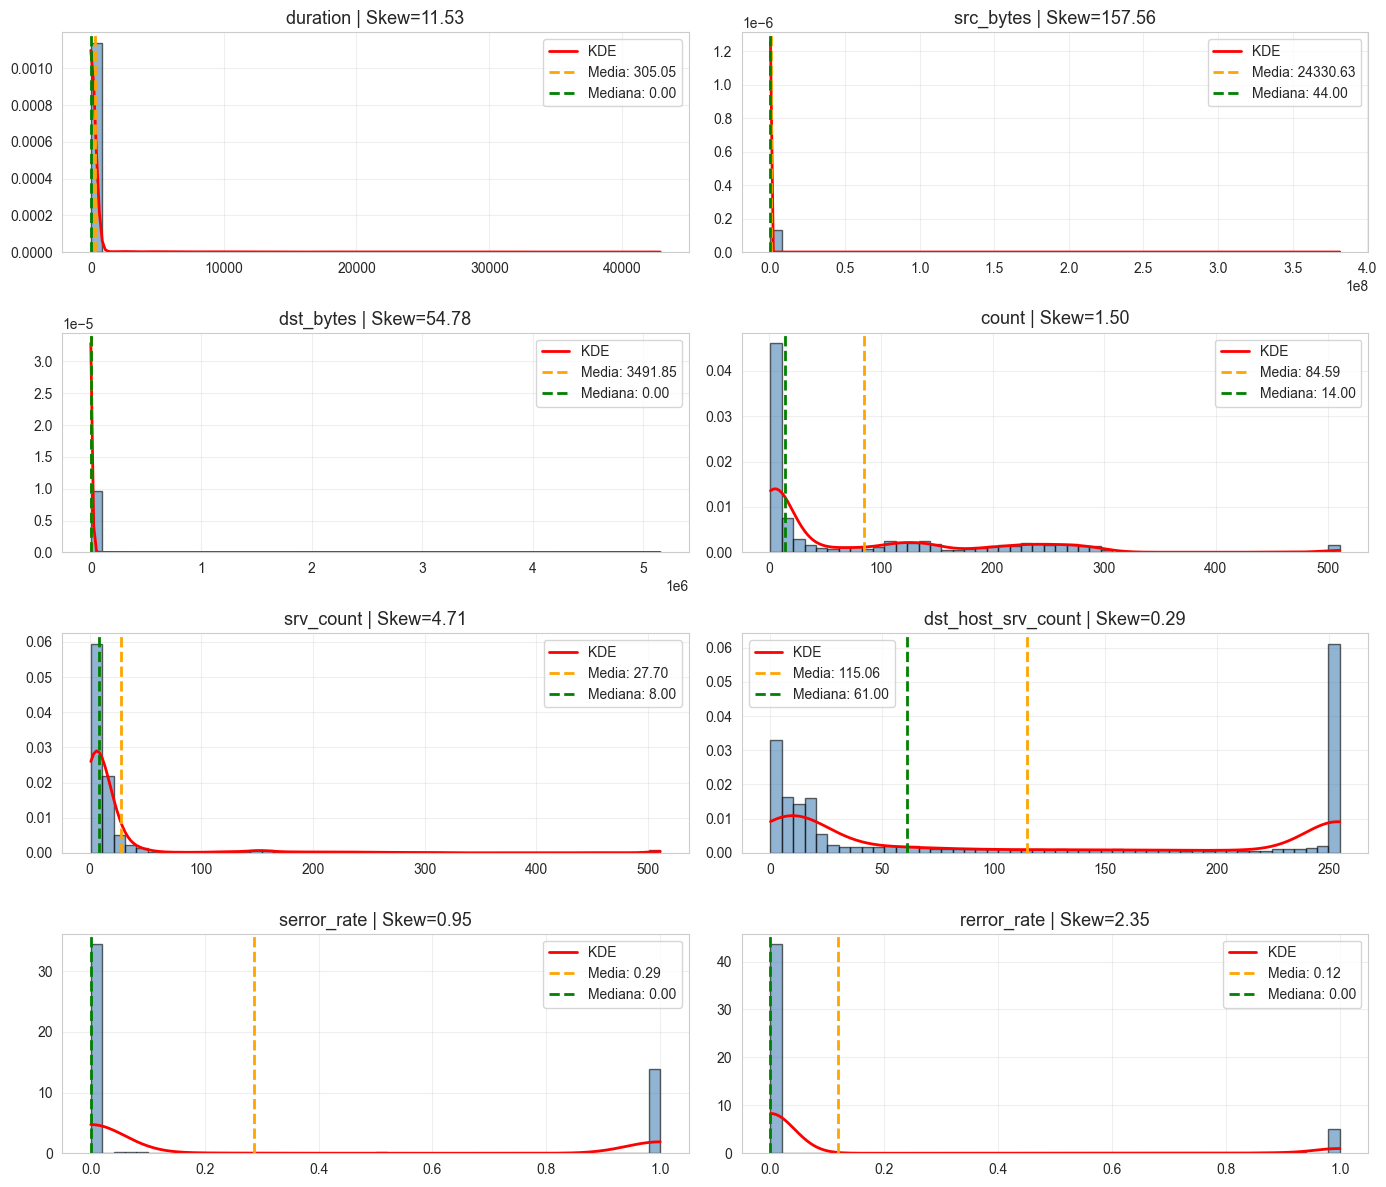

In [ ]:
key_numeric_vars = [
    'duration', 'src_bytes', 'dst_bytes',
    'count', 'srv_count', 'dst_host_srv_count',
    'serror_rate', 'rerror_rate'
]

fig, axes = plt.subplots(4, 2, figsize=(14, 12))
axes = axes.flatten()

for ax, var in zip(axes, key_numeric_vars):
    data = train_df[var].dropna()
    
    ax.hist(data, bins=50, density=True, alpha=0.6, color='steelblue', edgecolor='black')
    
    # Curva KDE (si tiene varianza)
    if data.std() > 0:

        from scipy.stats import gaussian_kde
        
        kde = gaussian_kde(data.dropna())
        x_range = np.linspace(data.min(), data.max(), 200)
        ax.plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')


    # Líneas de estadísticos clave
    mean_val = data.mean()
    median_val = data.median()
    ax.axvline(mean_val, color='orange', linestyle='--', linewidth=2, label=f'Media: {mean_val:.2f}')
    ax.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Mediana: {median_val:.2f}')
    
    ax.set_title(f'{var} | Skew={data.skew():.2f}')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Boxplots para diagnóstico visual de dispersión y colas

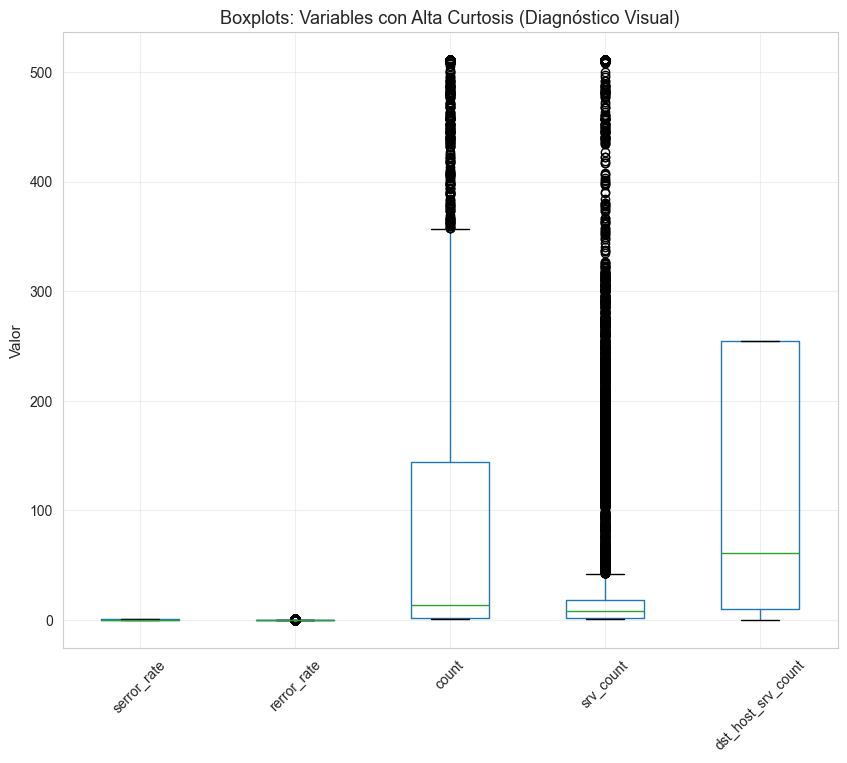

In [ ]:
high_kurt_vars = [
    'duration', 'src_bytes', 'dst_bytes',
    'count', 'srv_count', 'dst_host_srv_count'
]

plt.figure(figsize=(10, 8))
train_df[high_kurt_vars].boxplot(rot=45)
plt.title('Boxplots: Variables con Alta Curtosis (Diagnóstico Visual)')
plt.ylabel('Valor')
plt.grid(alpha=0.3)
plt.show()


#### 2.3.3 Distribuciones de Variables Binarias

Para variables binarias, utilizamos gráficos de barras simples que muestran la proporción de cada valor. Esto complementa la tabla numérica de la Sección 2.2.2.

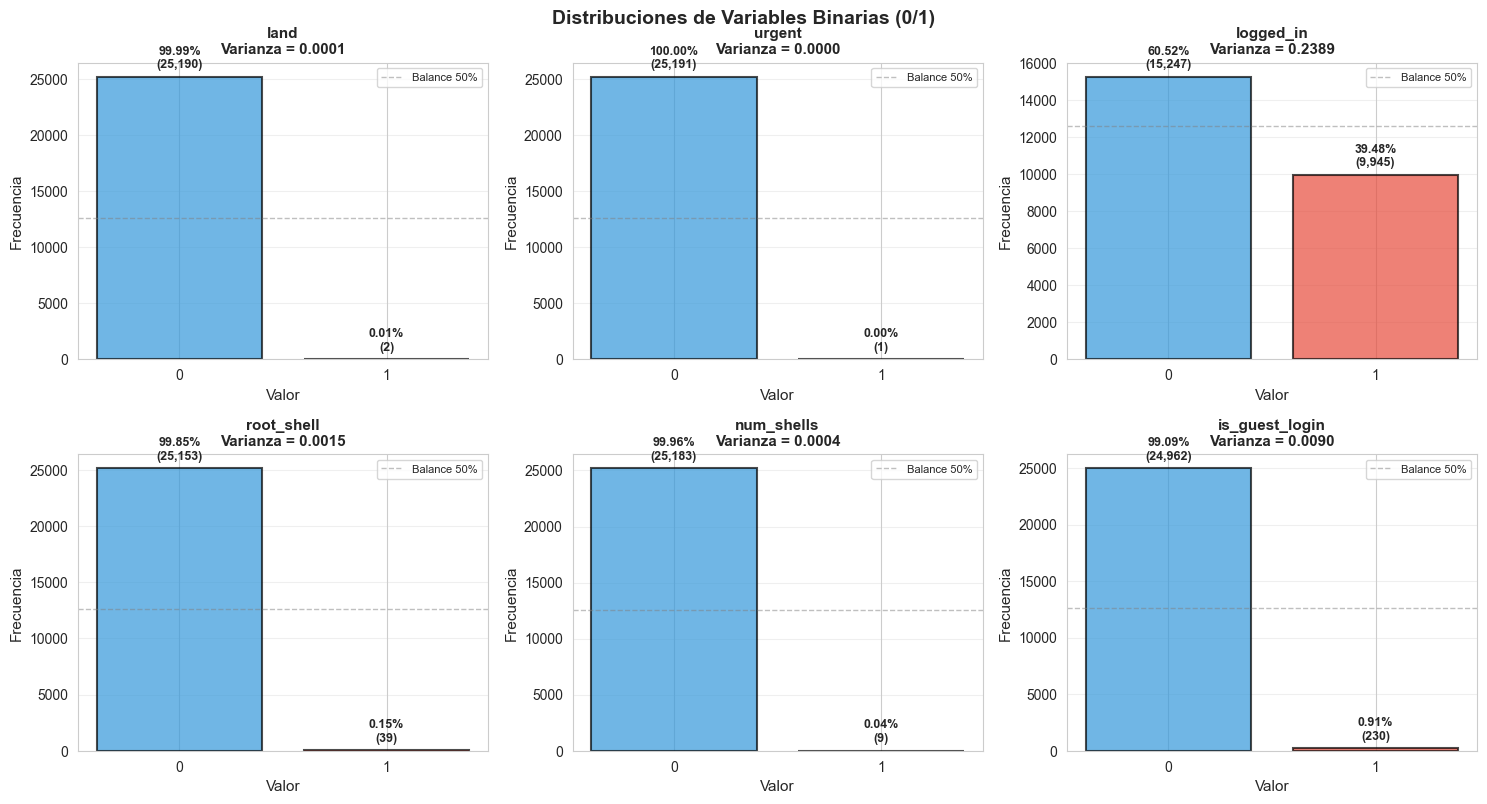

In [242]:
# Crear gráfico de barras para cada binaria
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, var in enumerate(binary_vars):
    ax = axes[idx]
    
    # Contar frecuencias
    counts = train_df[var].value_counts().sort_index()
    proportions = counts / len(train_df) * 100
    
    # Gráfico de barras
    bars = ax.bar(['0', '1'], counts, color=['#3498db', '#e74c3c'], 
                   alpha=0.7, edgecolor='black', linewidth=1.5)
    
    # Anotar porcentajes
    for bar, count, pct in zip(bars, counts, proportions):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + max(counts)*0.02,
                f'{pct:.2f}%\n({count:,})',
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Obtener varianza para el título
    var_val = binary_analysis.loc[var, 'Varianza']
    
    ax.set_title(f'{var}\nVarianza = {var_val:.4f}', 
                 fontsize=11, fontweight='bold')
    ax.set_xlabel('Valor')
    ax.set_ylabel('Frecuencia')
    ax.grid(alpha=0.3, axis='y')
    
    # Línea horizontal para frecuencia balanceada (50%)
    ax.axhline(len(train_df) * 0.5, color='gray', linestyle='--', 
               linewidth=1, alpha=0.5, label='Balance 50%')
    ax.legend(fontsize=8)

plt.tight_layout()
plt.suptitle('Distribuciones de Variables Binarias (0/1)', 
             fontsize=14, fontweight='bold', y=1.001)
plt.show()


#### 2.3.4 Distribuciones de Variables Categóricas

Visualizamos la distribución de frecuencias de las tres variables categóricas predictoras. Para `service` (66 categorías), mostramos solo las top 15 por claridad.

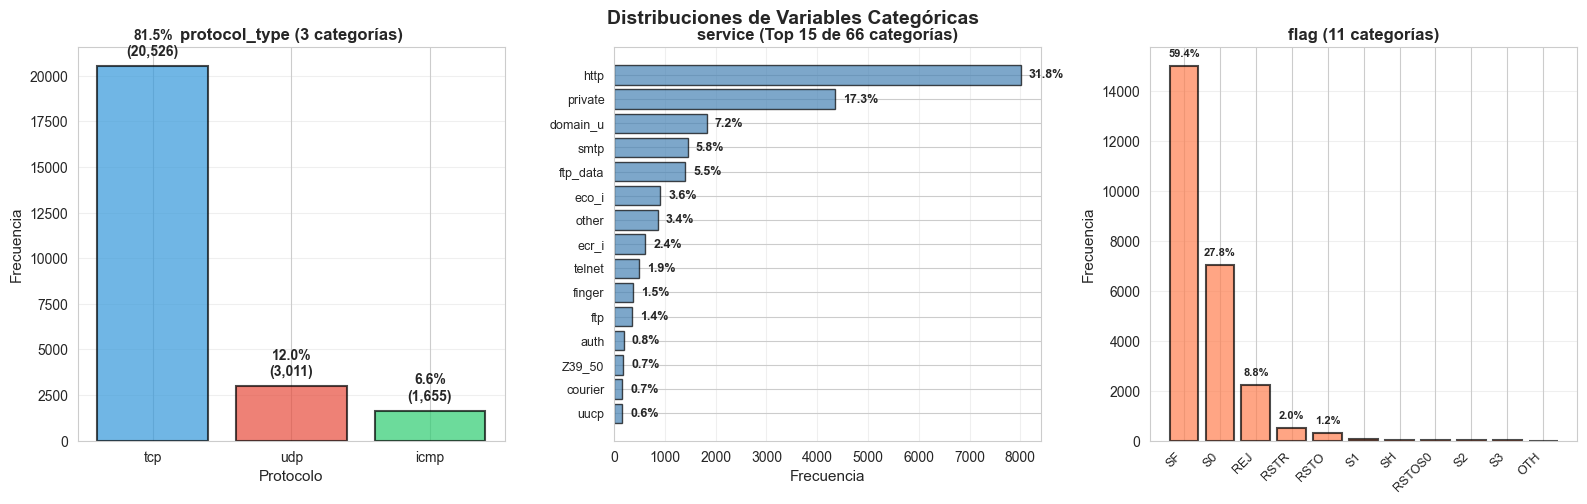

In [244]:
# 1. protocol_type (3 categorías - mostrar todas)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# --- PROTOCOL_TYPE ---
ax = axes[0]
protocol_counts = train_df['protocol_type'].value_counts()
colors_protocol = ['#3498db', '#e74c3c', '#2ecc71']
bars = ax.bar(protocol_counts.index, protocol_counts.values, 
              color=colors_protocol, alpha=0.7, edgecolor='black', linewidth=1.5)

# Anotar porcentajes
for bar, count in zip(bars, protocol_counts.values):
    pct = (count / len(train_df)) * 100
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + max(protocol_counts)*0.02,
            f'{pct:.1f}%\n({count:,})',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_title('protocol_type (3 categorías)', fontsize=12, fontweight='bold')
ax.set_xlabel('Protocolo')
ax.set_ylabel('Frecuencia')
ax.grid(alpha=0.3, axis='y')

# --- SERVICE (top 15) ---
ax = axes[1]
service_counts = train_df['service'].value_counts().head(15)
bars = ax.barh(range(len(service_counts)), service_counts.values, 
               color='steelblue', alpha=0.7, edgecolor='black', linewidth=1)

# Anotar porcentajes
for idx, (service, count) in enumerate(service_counts.items()):
    pct = (count / len(train_df)) * 100
    ax.text(count + max(service_counts)*0.02, idx,
            f'{pct:.1f}%',
            va='center', fontsize=9, fontweight='bold')

ax.set_yticks(range(len(service_counts)))
ax.set_yticklabels(service_counts.index, fontsize=9)
ax.set_title('service (Top 15 de 66 categorías)', fontsize=12, fontweight='bold')
ax.set_xlabel('Frecuencia')
ax.grid(alpha=0.3, axis='x')
ax.invert_yaxis()

# --- FLAG (11 categorías) ---
ax = axes[2]
flag_counts = train_df['flag'].value_counts()
bars = ax.bar(range(len(flag_counts)), flag_counts.values, 
              color='coral', alpha=0.7, edgecolor='black', linewidth=1.5)

# Anotar porcentajes
for idx, (flag, count) in enumerate(flag_counts.items()):
    pct = (count / len(train_df)) * 100
    if pct > 1.0:  # Solo anotar si > 1%
        ax.text(idx, count + max(flag_counts)*0.02,
                f'{pct:.1f}%',
                ha='center', va='bottom', fontsize=8, fontweight='bold')

ax.set_xticks(range(len(flag_counts)))
ax.set_xticklabels(flag_counts.index, rotation=45, ha='right', fontsize=9)
ax.set_title('flag (11 categorías)', fontsize=12, fontweight='bold')
ax.set_ylabel('Frecuencia')
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.suptitle('Distribuciones de Variables Categóricas', 
             fontsize=14, fontweight='bold', y=1.002)
plt.show()

---

### 2.4 Detección y Tratamiento de Valores Atípicos y Datos Faltantes

Los análisis anteriores revelaron la presencia masiva de valores extremos (outliers) en múltiples variables, particularmente aquellas relacionadas con volumen de tráfico y conteos. En esta sección abordamos una pregunta crítica para detección de intrusiones: **¿Son los outliers errores de medición o señales de ataque?**

A diferencia de problemas estándar de machine learning donde outliers suelen eliminarse, en detección de intrusiones los valores extremos son frecuentemente la **manifestación misma del comportamiento anómalo** que buscamos identificar. Por ello, aplicamos un enfoque contextual que considera tanto criterios estadísticos como conocimiento del dominio del problema.

**Metodología de análisis:**
1. Detección sistemática mediante dos métodos complementarios (IQR)
2. **Análisis crítico:** Distribución de outliers por categoría de ataque
3. Decisión fundamentada: mantener, transformar o eliminar

#### 2.4.1 Detección de Outliers: Método IQR de Tukey

El método IQR (Interquartile Range) es el estándar estadístico para detección de outliers basado en la dispersión robusta de los datos. Define como outliers aquellos valores que caen fuera del rango [Q1 - 1.5×IQR, Q3 + 1.5×IQR], donde IQR = Q3 - Q1.

**Ventajas del método:**
- Robusto a valores extremos (usa cuartiles, no media/desviación estándar)
- No asume normalidad de la distribución
- Ampliamente aceptado en análisis exploratorio

**Limitación:** En distribuciones muy asimétricas (como las nuestras), puede clasificar como outliers valores que son parte natural de la distribución de colas pesadas.

In [200]:
# ============================================================================
# 2.4.1 DETECCIÓN DE OUTLIERS - MÉTODO IQR DE TUKEY
# ============================================================================
print("DETECCIÓN DE OUTLIERS - MÉTODO IQR (INTERQUARTILE RANGE)")

print("\n📊 Método IQR (Tukey, 1977):")
print("   • Outlier inferior: x < Q1 - 1.5×IQR")
print("   • Outlier superior: x > Q3 + 1.5×IQR")
print("   • Donde IQR = Q3 - Q1 (rango intercuartílico)\n")

# Variables numéricas a analizar (excluir constantes y metadatos)
vars_to_analyze = [v for v in numeric_continuous 
                   if v not in ['num_outbound_cmds', 'is_host_login']]

# Calcular outliers para cada variable
outlier_summary_iqr = []

for var in vars_to_analyze:
    data = train_df[var]
    
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    
    lower_fence = q1 - 1.5 * iqr
    upper_fence = q3 + 1.5 * iqr
    
    outliers_lower = (data < lower_fence).sum()
    outliers_upper = (data > upper_fence).sum()
    total_outliers = outliers_lower + outliers_upper
    pct_outliers = (total_outliers / len(data)) * 100
    
    outlier_summary_iqr.append({
        'Variable': var,
        'Q1': q1,
        'Q3': q3,
        'IQR': iqr,
        'Lower_Fence': lower_fence,
        'Upper_Fence': upper_fence,
        'Outliers_Lower': outliers_lower,
        'Outliers_Upper': outliers_upper,
        'Total_Outliers': total_outliers,
        'Pct_Outliers': pct_outliers
    })

# Crear DataFrame y ordenar por % de outliers
outlier_df_iqr = pd.DataFrame(outlier_summary_iqr).sort_values('Pct_Outliers', ascending=False)

# Mostrar top 15 variables con más outliers
print("🔝 TOP 15 VARIABLES CON MAYOR % DE OUTLIERS (MÉTODO IQR):\n")
print(f"{'Variable':<30} {'Total Outliers':<15} {'% Outliers':<12} {'Sup':<8} {'Inf':<8}")
print("-" * 73)

for _, row in outlier_df_iqr.iterrows():
    if row['Total_Outliers'] > 0:
        print(f"{row['Variable']:<30} {int(row['Total_Outliers']):<15,} "
                f"{row['Pct_Outliers']:<12.2f} {int(row['Outliers_Upper']):<8,} {int(row['Outliers_Lower']):<8,}")

# Estadísticas generales
print(f"\n📈 ESTADÍSTICAS GENERALES (MÉTODO IQR):")
print(f"   • Promedio de outliers por variable: {outlier_df_iqr['Pct_Outliers'].mean():.2f}%")
print(f"   • Mediana de outliers por variable:  {outlier_df_iqr['Pct_Outliers'].median():.2f}%")
print(f"   • Variables con >20% outliers:       {(outlier_df_iqr['Pct_Outliers'] > 20).sum()}")
print(f"   • Variables con >10% outliers:       {(outlier_df_iqr['Pct_Outliers'] > 10).sum()}")
print(f"   • Variables con >5% outliers:        {(outlier_df_iqr['Pct_Outliers'] > 5).sum()}")

# Identificar variables con outliers solo superiores (asimetría a la derecha)
only_upper = outlier_df_iqr[(outlier_df_iqr['Outliers_Upper'] > 0) & 
                             (outlier_df_iqr['Outliers_Lower'] == 0)]

print(f"\n📊 ANÁLISIS DE ASIMETRÍA DE OUTLIERS:")
print(f"   • Variables con SOLO outliers superiores: {len(only_upper)}")
print(f"     (Confirma asimetría a la derecha detectada en Sección 2.2)")


DETECCIÓN DE OUTLIERS - MÉTODO IQR (INTERQUARTILE RANGE)

📊 Método IQR (Tukey, 1977):
   • Outlier inferior: x < Q1 - 1.5×IQR
   • Outlier superior: x > Q3 + 1.5×IQR
   • Donde IQR = Q3 - Q1 (rango intercuartílico)

🔝 TOP 15 VARIABLES CON MAYOR % DE OUTLIERS (MÉTODO IQR):

Variable                       Total Outliers  % Outliers   Sup      Inf     
-------------------------------------------------------------------------
srv_diff_host_rate             5,675           22.53        5,675    0       
dst_host_same_src_port_rate    4,987           19.80        4,987    0       
dst_bytes                      4,699           18.65        4,699    0       
dst_host_rerror_rate           4,504           17.88        4,504    0       
dst_host_srv_rerror_rate       3,843           15.25        3,843    0       
srv_rerror_rate                3,233           12.83        3,233    0       
rerror_rate                    3,207           12.73        3,207    0       
src_bytes                   

#### 2.4.2 Análisis de Distribución de Outliers por Categoría de Ataque

**Esta es la sección más crítica:** Determinar si los outliers están distribuidos uniformemente o concentrados en categorías específicas de ataque. Esta información guiará la decisión de mantener, transformar o eliminar outliers.

**Hipótesis a verificar:**
- **H1:** Outliers están concentrados en categorías de ataque → **MANTENER** (son señal)
- **H2:** Outliers están distribuidos uniformemente → Investigar si son errores de medición

Analizamos las **5 variables con mayor % de outliers y relevancia conceptual para la detección de instrusiones** identificadas en 2.4.1.

In [201]:
# ============================================================================
# 2.4.2 DISTRIBUCIÓN DE OUTLIERS POR CATEGORÍA - VARIABLES SELECCIONADAS
# ============================================================================
print("ANÁLISIS CRÍTICO: DISTRIBUCIÓN DE OUTLIERS POR CATEGORÍA DE ATAQUE")
print("\n🎯 OBJETIVO: Determinar si outliers son señales de ataque o ruido aleatorio\n")

# =========================================================================
# SELECCIÓN DE VARIABLES A ANALIZAR
# =========================================================================
# De las 15 variables con mayor % de outliers detectadas en 2.4.1,
# seleccionamos 5 basándonos en:
#   1. % de outliers significativo
#   2. Alta relevancia conceptual para detección de intrusiones

vars_to_analyze_detail = [
    'dst_bytes',      # 18.65% outliers - Volumen recibido (exfiltración)
    'rerror_rate',    # 12.73% outliers - Tasa errores REJ (escaneo puertos)
    'src_bytes',      # 10.82% outliers - Volumen enviado (DoS floods)
    'duration',       #  8.03% outliers - Duración conexión (DoS persistente)
    'count'           #  2.49% outliers - Conexiones en ventana (ráfagas)
]

# Justificación de cada variable
var_justifications = {
    'dst_bytes': 'Volumen recibido - Detecta exfiltración de datos, downloads sospechosos',
    'rerror_rate': 'Tasa de errores REJ - Característica de escaneos de puertos (Probe)',
    'src_bytes': 'Volumen enviado - Detecta DoS floods, data exfiltration',
    'duration': 'Duración de conexión - Detecta DoS persistentes (slowloris, long-lived)',
    'count': 'Conexiones en ventana temporal - Detecta ráfagas de ataques DoS/Probe'
}

print("📊 VARIABLES SELECCIONADAS PARA ANÁLISIS DETALLADO:\n")
print(f"{'Variable':<20} {'% Outliers':<12} {'Relevancia para IDS'}")
print("-" * 90)

for var in vars_to_analyze_detail:
    pct = outlier_df_iqr[outlier_df_iqr['Variable'] == var]['Pct_Outliers'].values[0]
    justif = var_justifications[var]
    print(f"{var:<20} {pct:<12.2f} {justif}")

print("\n💡 CRITERIO DE SELECCIÓN:")
print("   De las 15 variables con mayor % de outliers, seleccionamos estas 5 porque:")
print("   1. Representan aspectos CRÍTICOS del tráfico de red (volumen, duración, ráfagas, errores)")
print("   2. Tienen % de outliers significativo (2.49% - 18.65%)")
print("\n")

# =========================================================================
# ANÁLISIS DETALLADO POR VARIABLE Y CATEGORÍA
# =========================================================================

outlier_by_category_summary = []

for var in vars_to_analyze_detail:

    
    # Calcular fences
    q1 = train_df[var].quantile(0.25)
    q3 = train_df[var].quantile(0.75)
    iqr = q3 - q1
    upper_fence = q3 + 1.5 * iqr
    
    # Identificar outliers
    is_outlier = train_df[var] > upper_fence
    
    # Contar outliers por categoría
    outlier_counts_by_cat = train_df[is_outlier]['attack_category'].value_counts()
    total_by_cat = train_df['attack_category'].value_counts()
    
    total_outliers = is_outlier.sum()
    
    for cat in category_order:
        total_cat = total_by_cat.get(cat, 0)
        outliers_cat = outlier_counts_by_cat.get(cat, 0)
        
        if total_cat > 0:
            pct_outliers_in_cat = (outliers_cat / total_cat) * 100
        else:
            pct_outliers_in_cat = 0
        
        if total_outliers > 0:
            pct_of_total_outliers = (outliers_cat / total_outliers) * 100
        else:
            pct_of_total_outliers = 0
        
        outlier_by_category_summary.append({
            'Variable': var,
            'Categoria': cat,
            'Total_Obs': total_cat,
            'Outliers': outliers_cat,
            'Pct_Outliers_en_Cat': pct_outliers_in_cat,
            'Pct_del_Total_Outliers': pct_of_total_outliers
        })
    

# Guardar resumen
outlier_by_cat_df = pd.DataFrame(outlier_by_category_summary)

ANÁLISIS CRÍTICO: DISTRIBUCIÓN DE OUTLIERS POR CATEGORÍA DE ATAQUE

🎯 OBJETIVO: Determinar si outliers son señales de ataque o ruido aleatorio

📊 VARIABLES SELECCIONADAS PARA ANÁLISIS DETALLADO:

Variable             % Outliers   Relevancia para IDS
------------------------------------------------------------------------------------------
dst_bytes            18.65        Volumen recibido - Detecta exfiltración de datos, downloads sospechosos
rerror_rate          12.73        Tasa de errores REJ - Característica de escaneos de puertos (Probe)
src_bytes            10.82        Volumen enviado - Detecta DoS floods, data exfiltration
duration             8.03         Duración de conexión - Detecta DoS persistentes (slowloris, long-lived)
count                2.49         Conexiones en ventana temporal - Detecta ráfagas de ataques DoS/Probe

💡 CRITERIO DE SELECCIÓN:
   De las 15 variables con mayor % de outliers, seleccionamos estas 5 porque:
   1. Representan aspectos CRÍTICOS del tráfico

VISUALIZACIÓN: TASA DE OUTLIERS POR CATEGORÍA DE ATAQUE


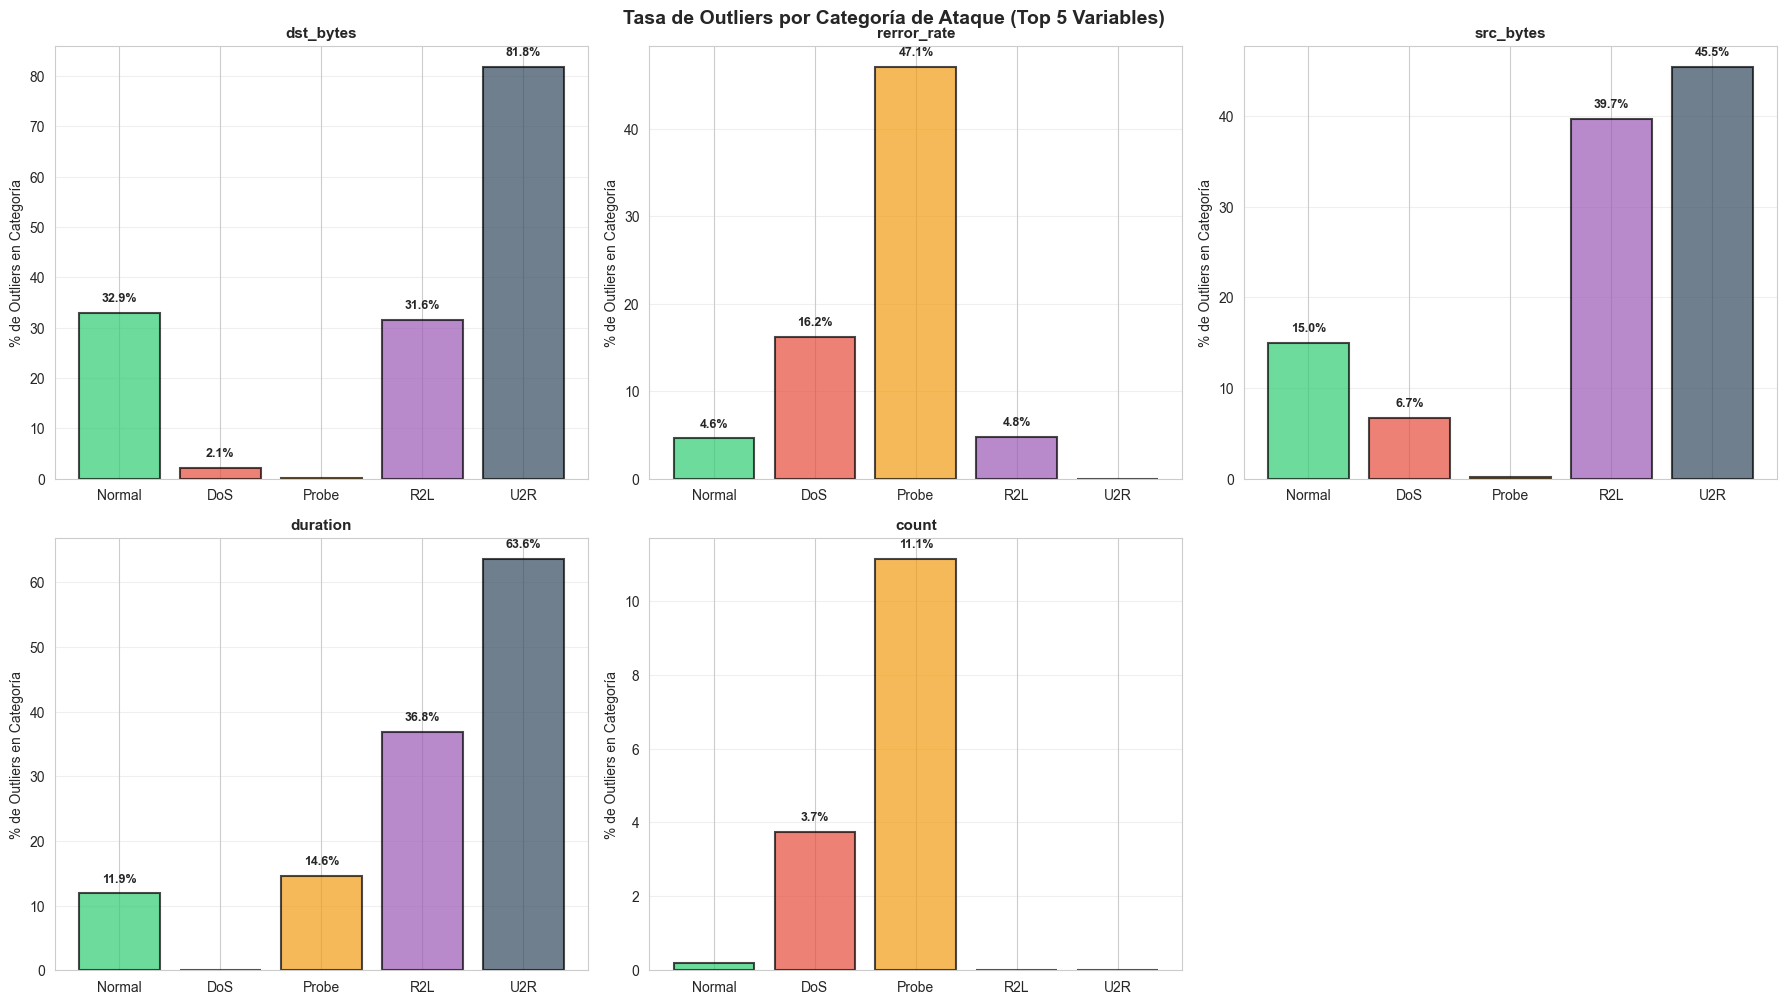

✅ Visualización completada



In [202]:
# ============================================================================
# VISUALIZACIÓN: DISTRIBUCIÓN DE OUTLIERS POR CATEGORÍA
# ============================================================================
print("VISUALIZACIÓN: TASA DE OUTLIERS POR CATEGORÍA DE ATAQUE")
# Crear gráfico de barras agrupadas
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, var in enumerate(vars_to_analyze_detail):
    ax = axes[idx]
    
    # Filtrar datos de esta variable
    data_var = outlier_by_cat_df[outlier_by_cat_df['Variable'] == var]
    
    # Crear gráfico de barras
    categories = data_var['Categoria'].tolist()
    pct_outliers = data_var['Pct_Outliers_en_Cat'].tolist()
    
    bars = ax.bar(range(len(categories)), pct_outliers, 
                   color=[attack_colors[cat] for cat in categories],
                   alpha=0.7, edgecolor='black', linewidth=1.5)
    
    # Anotar valores
    for i, (cat, pct) in enumerate(zip(categories, pct_outliers)):
        if pct > 0.5:  # Solo anotar si es visible
            ax.text(i, pct + max(pct_outliers)*0.02, f'{pct:.1f}%',
                   ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    ax.set_xticks(range(len(categories)))
    ax.set_xticklabels(categories, rotation=0, fontsize=10)
    ax.set_ylabel('% de Outliers en Categoría', fontsize=10)
    ax.set_title(f'{var}', fontsize=11, fontweight='bold')
    ax.grid(alpha=0.3, axis='y')

# Ocultar subplot extra
fig.delaxes(axes[5])

plt.tight_layout()
plt.suptitle('Tasa de Outliers por Categoría de Ataque (Top 5 Variables)', 
             fontsize=14, fontweight='bold', y=1.001)
plt.show()

print("✅ Visualización completada\n")

#### 2.4.3 Decisiones de Tratamiento de Outliers y Justificación

Basándonos en el análisis de distribución de outliers por categoría de ataque, tomamos decisiones fundamentadas sobre el tratamiento de valores atípicos. **El criterio central es contextual:** Si outliers están concentrados en categorías de ataque con ratios significativos (>2x respecto a Normal), son señales informativas que deben mantenerse.

**Principios de decisión:**
1. **Mantener outliers** cuando ratio (ataque/Normal) > 2x → Señal discriminativa
2. **No eliminar outliers** incluso si predominan en Normal → Pueden representar uso legítimo extremo
3. **Considerar transformaciones logarítmicas** para variables con asimetría extrema (Skew > 10) en fase de modelado
4. **Documentar** cada decisión con evidencia cuantitativa del análisis por categoría

In [203]:
# ============================================================================
# 2.4.3 DECISIONES DE TRATAMIENTO DE OUTLIERS
# ============================================================================
print("DECISIONES DE TRATAMIENTO DE OUTLIERS")

print("\n🎯 CRITERIO: Ratio (Ataque/Normal) > 2x → Outliers son señal discriminativa\n")

# =========================================================================
# TABLA DE DECISIONES BASADA EN ANÁLISIS POR CATEGORÍA
# =========================================================================

decisions_data = [
    {
        'Variable': 'dst_bytes',
        'Categoria_Max': 'U2R (81.82%)',
        'Normal': '32.91%',
        'Ratio': '2.5x',
        'Decision': 'MANTENER',
        'Justificacion': 'U2R ratio significativo; asimetría extrema (Skew=54.77)'
    },
    {
        'Variable': 'rerror_rate',
        'Categoria_Max': 'Probe (47.09%)',
        'Normal': '4.60%',
        'Ratio': '10.2x',
        'Decision': 'MANTENER',
        'Justificacion': 'Discriminador excelente; variable ya acotada [0,1]'
    },
    {
        'Variable': 'src_bytes',
        'Categoria_Max': 'U2R (45.45%)',
        'Normal': '14.96%',
        'Ratio': '3.0x',
        'Decision': 'MANTENER',
        'Justificacion': 'U2R/R2L ratios significativos; asimetría extrema (Skew=157.55)'
    },
    {
        'Variable': 'duration',
        'Categoria_Max': 'U2R (63.64%)',
        'Normal': '11.89%',
        'Ratio': '5.4x',
        'Decision': 'MANTENER',
        'Justificacion': 'U2R/R2L ratios altos; asimetría extrema (Skew=11.53)'
    },
    {
        'Variable': 'count',
        'Categoria_Max': 'Probe (11.14%)',
        'Normal': '0.19%',
        'Ratio': '57.6x',
        'Decision': 'MANTENER',
        'Justificacion': 'Discriminador excepcional; 95.85% outliers en ataques'
    }
]

decisions_df = pd.DataFrame(decisions_data)

print("📊 RESUMEN DE DECISIONES POR VARIABLE\n")
print(decisions_df.to_string(index=False))

# =========================================================================
# HALLAZGOS CLAVE Y ESTRATEGIA GLOBAL
# =========================================================================

print("HALLAZGOS CLAVE Y ESTRATEGIA GLOBAL")

print("""
✅ DECISIÓN GENERAL: MANTENER TODOS LOS OUTLIERS

Justificación:
1. Ratios 2.5x - 57.6x demuestran que outliers NO son ruido aleatorio
2. Cada tipo de ataque tiene "firma" específica de outliers
3. Outliers en Normal representan uso legítimo extremo (no errores)
4. Técnicas posteriores son robustas (pruebas no paramétricas, covarianza robusta)
""")

print("\n")
print("✅ SECCIÓN 2.4 COMPLETADA: Detección y Tratamiento de Outliers")

DECISIONES DE TRATAMIENTO DE OUTLIERS

🎯 CRITERIO: Ratio (Ataque/Normal) > 2x → Outliers son señal discriminativa

📊 RESUMEN DE DECISIONES POR VARIABLE

   Variable  Categoria_Max Normal Ratio Decision                                                  Justificacion
  dst_bytes   U2R (81.82%) 32.91%  2.5x MANTENER        U2R ratio significativo; asimetría extrema (Skew=54.77)
rerror_rate Probe (47.09%)  4.60% 10.2x MANTENER             Discriminador excelente; variable ya acotada [0,1]
  src_bytes   U2R (45.45%) 14.96%  3.0x MANTENER U2R/R2L ratios significativos; asimetría extrema (Skew=157.55)
   duration   U2R (63.64%) 11.89%  5.4x MANTENER           U2R/R2L ratios altos; asimetría extrema (Skew=11.53)
      count Probe (11.14%)  0.19% 57.6x MANTENER          Discriminador excepcional; 95.85% outliers en ataques
HALLAZGOS CLAVE Y ESTRATEGIA GLOBAL

✅ DECISIÓN GENERAL: MANTENER TODOS LOS OUTLIERS

Justificación:
1. Ratios 2.5x - 57.6x demuestran que outliers NO son ruido aleatorio
2. C

---

### 2.5 Análisis Bivariado: Relaciones entre Variables y Categorías de Ataque

El análisis univariado (Secciones 2.2 y 2.3) caracterizó cada variable individualmente. Ahora examinamos **relaciones entre variables**, específicamente cómo las variables descriptoras se relacionan con las categorías de ataque.

**Metodología:** Organizamos el análisis en tres tipos de relaciones bivariadas:
- **Numérica × Categórica:** Comparar distribuciones de variables numéricas entre categorías de ataque
- **Categórica × Categórica:** Analizar asociaciones entre variables categóricas y categorías de ataque
- **Numérica × Numérica:** Examinar correlaciones entre pares de variables numéricas

---



#### 2.5.1 Comparación de Distribuciones: Variables Numéricas por Categoría de Ataque

**Objetivo:** Identificar variables numéricas cuyas distribuciones varían significativamente entre categorías de ataque, indicando poder discriminante.

**Metodología:** Utilizamos boxplots agrupados para las variables que mostraron alta relevancia en análisis previos (alta variabilidad en 2.3.1, concentración de outliers en 2.4). Complementamos con estadísticos comparativos (medianas, IQR) por categoría.

**Criterio de selección:** Variables con:
1. Alta relevancia conceptual para IDS
2. Variabilidad significativa (CV > 1 o outliers > 5%)
3. Balance entre profundidad de análisis y extensión (seleccionamos 8 variables representativas)

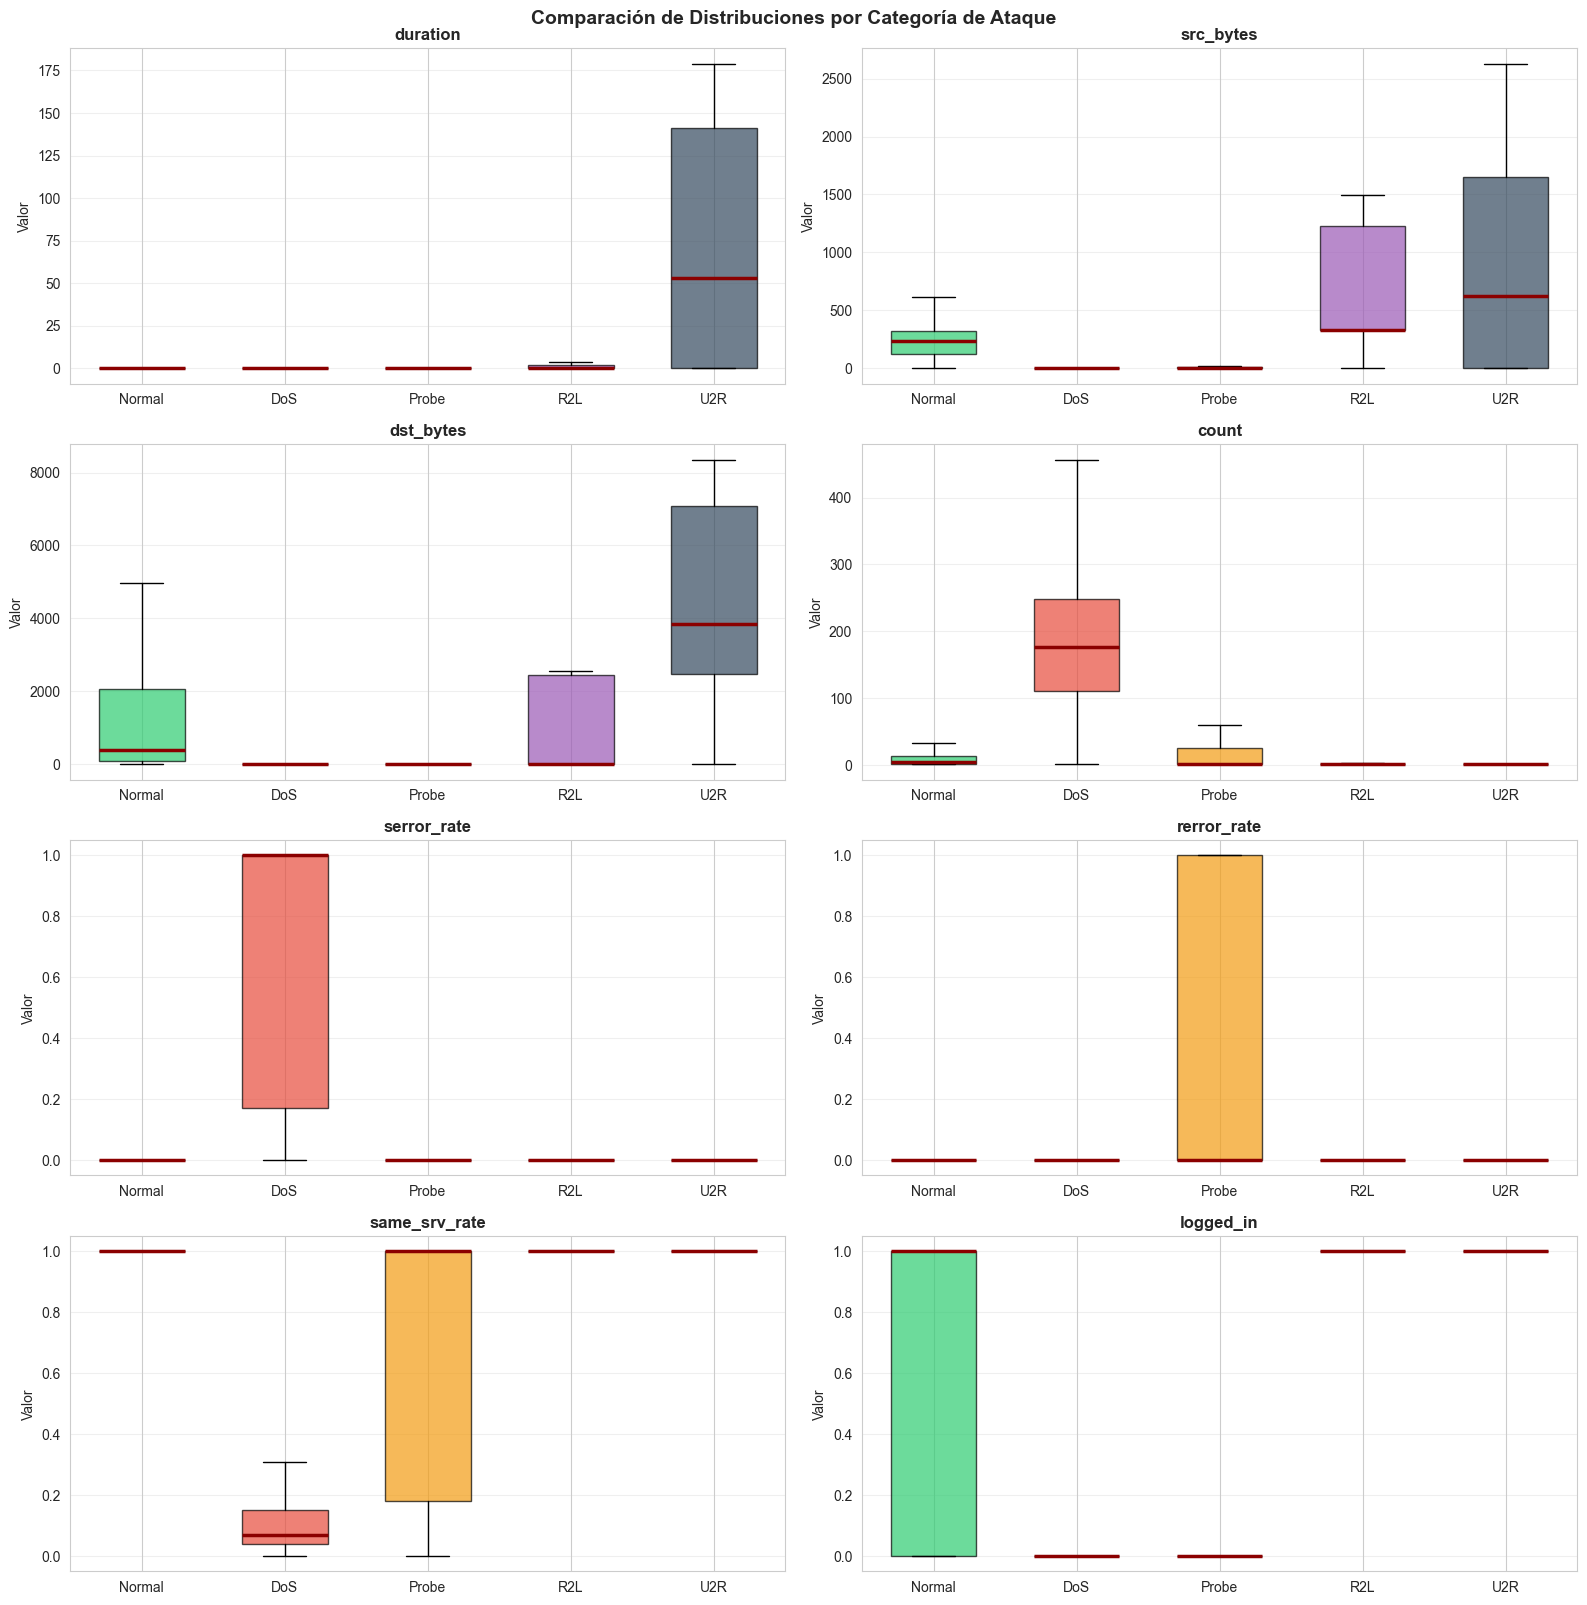


📊 MEDIANAS POR CATEGORÍA (Variables Clave)

   Variable  Normal   DoS  Probe   R2L    U2R
   duration     0.0   0.0    0.0   0.0   53.0
  src_bytes   234.0   0.0    1.0 334.0  621.0
  dst_bytes   382.0   0.0    0.0   0.0 3860.0
      count     4.0 177.0    1.0   1.0    1.0
serror_rate     0.0   1.0    0.0   0.0    0.0


In [204]:
# ============================================================================
# 2.5.1 BOXPLOTS COMPARATIVOS POR CATEGORÍA DE ATAQUE
# ============================================================================

# Variables seleccionadas (alta relevancia IDS + variabilidad)
bivariado_vars = [
    'duration', 'src_bytes', 'dst_bytes', 'count',
    'serror_rate', 'rerror_rate', 'same_srv_rate', 'logged_in'
]

# Boxplots agrupados
fig, axes = plt.subplots(4, 2, figsize=(16, 16))
axes = axes.flatten()

for idx, var in enumerate(bivariado_vars):
    ax = axes[idx]
    
    # Preparar datos por categoría
    data_by_cat = [train_df[train_df['attack_category'] == cat][var].dropna()
                   for cat in category_order]
    
    # Boxplot
    bp = ax.boxplot(data_by_cat, labels=category_order, patch_artist=True,
                    widths=0.6, showfliers=False)  # Sin outliers para claridad visual
    
    # Colorear según categoría
    for patch, color in zip(bp['boxes'], [attack_colors[cat] for cat in category_order]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    for median in bp['medians']:
        median.set_color('darkred')
        median.set_linewidth(2.5)
    
    ax.set_title(f'{var}', fontsize=12, fontweight='bold')
    ax.set_ylabel('Valor', fontsize=10)
    ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.suptitle('Comparación de Distribuciones por Categoría de Ataque', 
             fontsize=14, fontweight='bold', y=1.001)
plt.show()

# Tabla de medianas por categoría (muestra representativa)
print("\n📊 MEDIANAS POR CATEGORÍA (Variables Clave)\n")

medianas_comparativas = []
for var in ['duration', 'src_bytes', 'dst_bytes', 'count', 'serror_rate']:
    row = {'Variable': var}
    for cat in category_order:
        row[cat] = train_df[train_df['attack_category'] == cat][var].median()
    medianas_comparativas.append(row)

medianas_df = pd.DataFrame(medianas_comparativas)
print(medianas_df.to_string(index=False))

#### 2.5.2 Análisis de Asociación: Variables Categóricas vs. Categorías de Ataque

**Objetivo:** Examinar si variables categóricas (`protocol_type`, `service`, `flag`) están asociadas con categorías de ataque específicas.

**Metodología:** Construimos tablas de contingencia (crosstabs) y visualizamos con heatmaps de proporciones. Una asociación fuerte indica que ciertos valores de la variable categórica son más frecuentes en categorías específicas de ataque.

**Ejemplo de interpretación:** Si la mayoría de ataques Probe usan TCP mientras Normal usa distribución balanceada TCP/UDP/ICMP, esto indica que `protocol_type` tiene poder discriminante para Probe.

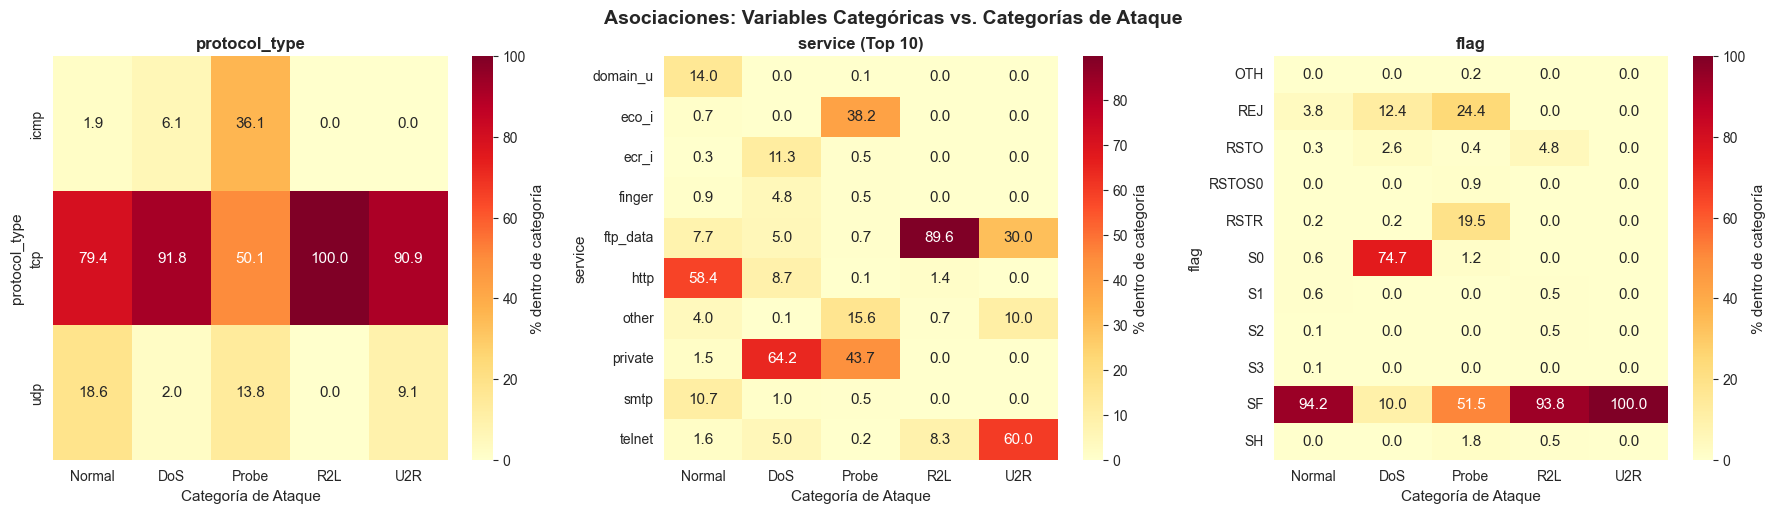

In [205]:
# ============================================================================
# 2.5.2 TABLAS DE CONTINGENCIA Y HEATMAPS
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

categorical_vars = ['protocol_type', 'service', 'flag']

for idx, var in enumerate(categorical_vars):
    ax = axes[idx]
    
    # Tabla de contingencia (proporciones por categoría de ataque)
    if var == 'service':
        # Para service, usar solo top 10 por claridad
        top_services = train_df['service'].value_counts().head(10).index
        contingency = pd.crosstab(
            train_df[train_df['service'].isin(top_services)]['service'],
            train_df[train_df['service'].isin(top_services)]['attack_category'],
            normalize='columns'
        ) * 100
    else:
        contingency = pd.crosstab(
            train_df[var], 
            train_df['attack_category'],
            normalize='columns'
        ) * 100
    
    # Heatmap
    sns.heatmap(contingency, annot=True, fmt='.1f', cmap='YlOrRd', 
                ax=ax, cbar_kws={'label': '% dentro de categoría'})
    
    title = f'{var}' if var != 'service' else f'{var} (Top 10)'
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Categoría de Ataque')
    ax.set_ylabel(var)

plt.tight_layout()
plt.suptitle('Asociaciones: Variables Categóricas vs. Categorías de Ataque', 
             fontsize=14, fontweight='bold', y=1.02)
plt.show()

#### 2.5.3 Correlaciones Bivariadas entre Variables Numéricas

**Objetivo:** Identificar correlaciones lineales entre pares de variables numéricas para detectar multicolinealidad y relaciones redundantes.

**Metodología:** Calculamos la matriz de correlación de Pearson para variables numéricas continuas. Correlaciones |r| > 0.8 indican multicolinealidad potencial que puede causar problemas en regresión lineal.

**Implicaciones:**
- **Alta correlación (|r| > 0.8):** Variables redundantes; considerar eliminar una o usar PCA para reducción dimensional.
- **Correlación moderada (0.5 < |r| < 0.8):** Variables relacionadas pero no redundantes; útiles en conjunto.
- **Baja correlación (|r| < 0.5):** Variables independientes; aportan información complementaria.

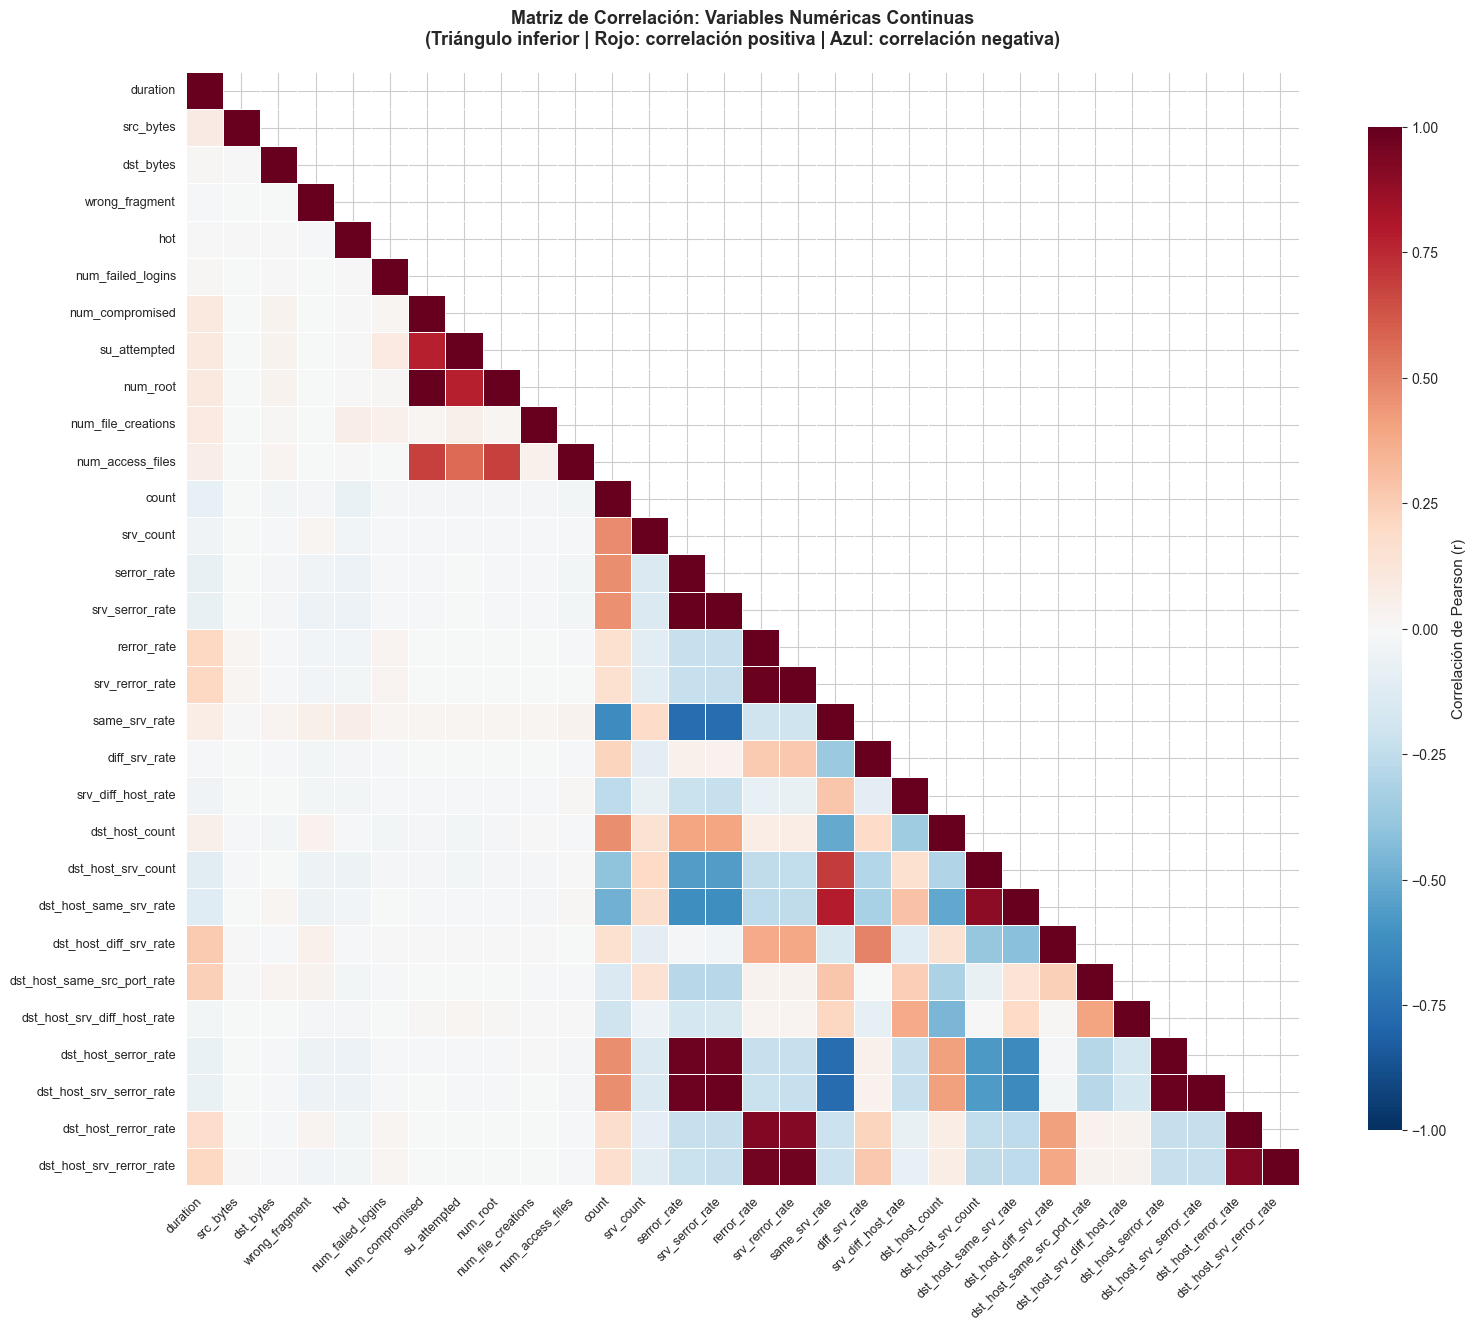


🔍 ANÁLISIS DE MULTICOLINEALIDAD

⚠️  MULTICOLINEALIDAD DETECTADA: 14 pares con |r| > 0.8

Variable 1                     Variable 2                     r         
----------------------------------------------------------------------
num_compromised                num_root                          0.999
serror_rate                    srv_serror_rate                   0.993
rerror_rate                    srv_rerror_rate                   0.989
dst_host_serror_rate           dst_host_srv_serror_rate          0.985
srv_serror_rate                dst_host_srv_serror_rate          0.985
serror_rate                    dst_host_srv_serror_rate          0.980
serror_rate                    dst_host_serror_rate              0.978
srv_serror_rate                dst_host_serror_rate              0.976
srv_rerror_rate                dst_host_srv_rerror_rate          0.970
rerror_rate                    dst_host_srv_rerror_rate          0.965
rerror_rate                    dst_host_rerror_rate    

In [206]:
# ============================================================================
# 2.5.3 MATRIZ DE CORRELACIÓN - VERSIÓN MEJORADA
# ============================================================================

# Seleccionar variables numéricas continuas (excluir binarias y metadatos)
numeric_for_corr = [v for v in numeric_continuous 
                    if v not in ['num_outbound_cmds', 'is_host_login'] 
                    and v in train_df.columns]

# Calcular matriz de correlación
corr_matrix = train_df[numeric_for_corr].corr()

# ============================================================================
# VISUALIZACIÓN MEJORADA
# ============================================================================

# Crear figura con tamaño apropiado
fig, ax = plt.subplots(figsize=(16, 14))

# Crear máscara para triángulo superior (evitar duplicación)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

# Heatmap con configuración mejorada
sns.heatmap(
    corr_matrix, 
    mask=mask,                    # Solo mostrar triángulo inferior
    annot=False,                  # Sin anotaciones (demasiadas variables)
    cmap='RdBu_r',                # Rojo-Blanco-Azul (divergente, centrado en 0)
    center=0,                     # Centro en 0
    vmin=-1, vmax=1,              # Rango completo de correlaciones
    square=True,                  # Celdas cuadradas
    linewidths=0.5,               # Líneas de separación sutiles
    cbar_kws={
        'label': 'Correlación de Pearson (r)',
        'shrink': 0.8,
        'aspect': 30
    },
    ax=ax
)

# Mejorar etiquetas
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=9)

# Título descriptivo
ax.set_title(
    'Matriz de Correlación: Variables Numéricas Continuas\n' +
    '(Triángulo inferior | Rojo: correlación positiva | Azul: correlación negativa)',
    fontsize=13, 
    fontweight='bold',
    pad=20
)

plt.tight_layout()
plt.show()

# ============================================================================
# ANÁLISIS CUANTITATIVO: IDENTIFICAR PARES CON ALTA CORRELACIÓN
# ============================================================================

print("\n🔍 ANÁLISIS DE MULTICOLINEALIDAD")

# Identificar correlaciones altas (|r| > 0.8, excluyendo diagonal)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.8:
            high_corr_pairs.append({
                'Variable_1': corr_matrix.columns[i],
                'Variable_2': corr_matrix.columns[j],
                'Correlacion': corr_val,
                'Abs_Correlacion': abs(corr_val)
            })

if high_corr_pairs:
    print(f"\n⚠️  MULTICOLINEALIDAD DETECTADA: {len(high_corr_pairs)} pares con |r| > 0.8\n")
    
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values(
        'Abs_Correlacion', 
        ascending=False
    )
    
    # Tabla formateada
    print(f"{'Variable 1':<30} {'Variable 2':<30} {'r':<10}")
    print("-" * 70)
    
    for _, row in high_corr_df.iterrows():
        print(f"{row['Variable_1']:<30} {row['Variable_2']:<30} {row['Correlacion']:>8.3f}")
    
    # Recomendaciones
    print("\n💡 IMPLICACIONES:")
    print("   • Pares con |r| > 0.8 contienen información redundante")
    
else:
    print("\n✅ No se detectaron correlaciones fuertes (|r| > 0.8)")
    print("   Las variables numéricas son relativamente independientes")


**Interpretación de correlaciones altas:**

La presencia de correlaciones |r| > 0.8 indica multicolinealidad, común en datasets de tráfico de red donde variables derivadas (ej: `dst_host_srv_count` vs. `srv_count`) miden conceptos relacionados.

**Estrategias para manejar multicolinealidad:**
- **Reducción dimensional (PCA):** Transformar variables correlacionadas en componentes ortogonales (Sección 4.3).

Las correlaciones identificadas aquí informarán decisiones en Sección 3 (Preparación de Datos) sobre qué variables retener para modelado.

---

#### 2.7.2 Preguntas de Investigación

Este proyecto busca responder tres preguntas fundamentales que, en conjunto, validan si el análisis estadístico del comportamiento del tráfico de red puede servir como base para detección y clasificación de intrusiones sin depender de firmas conocidas.

---

**Pregunta 1: ¿Tienen los ataques "huellas digitales" estadísticamente distinguibles?**

**Motivación:** 
Cuando un atacante escanea una red (Probe), lanza una denegación de servicio (DoS), o intenta acceso no autorizado (R2L/U2R), ¿deja una "firma estadística" en el tráfico de red que lo diferencia del comportamiento legítimo? Si estas firmas existen y son estadísticamente significativas, podríamos detectar intrusiones sin conocer el ataque específico, simplemente reconociendo que el patrón observado es **anormalmente diferente** del tráfico normal.

**Pregunta formal:** 
*¿Las distribuciones de características clave del tráfico (`src_bytes`, `dst_bytes`, `duration`, `serror_rate`, `count`) difieren estadísticamente entre tráfico normal y los cuatro tipos de ataque, de manera que cada categoría tenga una "huella digital" distinguible?*

---

**Pregunta 2: ¿Podemos comprimir la complejidad del tráfico de red sin perder su poder discriminante?**

**Motivación:** 
Caracterizar tráfico de red requiere monitorear simultáneamente 32 variables (duración, volumen de bytes, tasas de error, conteos de conexiones, etc.). Esta alta dimensionalidad presenta dos problemas críticos: (1) **multicolinealidad severa** (14 pares de variables con |r| > 0.8 miden esencialmente lo mismo), y (2) **imposibilidad de visualización** y comprensión de patrones en espacios de más de 3 dimensiones.

¿Existe un conjunto reducido de "meta-variables" (componentes principales) que capture la esencia del comportamiento de red, eliminando redundancia y permitiendo visualizar la separación entre tráfico normal y ataques en espacios interpretables?

**Pregunta formal:** 
*¿Cuántos componentes principales capturan ≥85% de la variabilidad del tráfico de red según el criterio del codo? ¿Qué variables originales tienen mayor contribución (loadings) a estos componentes? ¿Es posible visualizar separabilidad clara entre categorías de ataque proyectando los datos en espacios reducidos 2D/3D?*

---

**Pregunta 3: ¿Podemos predecir tipos específicos de ataque usando las "dimensiones esenciales" del tráfico?**

**Motivación:** 
Detectar que "algo anormal está ocurriendo" es útil, pero **identificar qué tipo de ataque** permite respuestas específicas y proporcionales:
- **DoS** → Activar mitigaciones de sobrecarga (rate limiting, filtrado, CDN)
- **Probe** → Bloquear IP escaneadora, alertar equipo de seguridad, honeypots
- **R2L/U2R** → Auditoría urgente de credenciales, análisis forense, aislamiento de segmentos

Si los componentes principales (de P2) efectivamente capturan patrones discriminantes, ¿podemos entrenar modelos predictivos que identifiquen cada tipo de ataque con precisión aceptable, incluso enfrentando el desbalance extremo del dataset (R2L: 0.83%, U2R: 0.04%)?

**Pregunta formal:** 
*¿Es factible construir modelos de regresión logística binaria que predigan cada categoría de ataque (DoS vs Resto, Probe vs Resto, R2L vs Resto, U2R vs Resto) usando componentes principales como features? ¿Qué componentes principales (y por ende, qué aspectos del tráfico original) son más predictivos para cada tipo de ataque?*

---

**Narrativa Cohesiva de las Tres Preguntas:**

**P1** establece la existencia (las firmas estadísticas son reales y distinguibles).

**P2** reduce la complejidad preservando la información discriminante (de 32 variables a ~10-15 componentes interpretables).

**P3** demuestra utilidad práctica (los patrones comprimidos permiten predecir tipos específicos de ataque con métricas evaluables).

**Juntas, las tres preguntas responden la interrogante central del proyecto:** 

*¿Podemos detectar **Y** clasificar intrusiones de red basándonos únicamente en análisis estadístico del comportamiento del tráfico, sin depender de firmas de ataque conocidas, validando el enfoque de detección basada en anomalías estadísticas como alternativa complementaria a sistemas basados en reglas?*

## 3. Preparación de Datos

La preparación de datos transforma el dataset explorado en la Sección 2 en un formato adecuado para aplicar las técnicas estadísticas que responderán las preguntas de investigación formuladas en la Sección 2.7. Este proceso incluye limpieza, transformación de variables, y creación de subconjuntos específicos para cada análisis.

---

### 3.1 Limpieza: Eliminación de Variables Constantes y de Baja Varianza

**Justificación:** Variables sin varianza o con varianza despreciable no aportan información discriminativa y pueden causar problemas numéricos en algoritmos como PCA y regresión logística.

---

In [207]:
# ============================================================================
# 3.1 ELIMINACIÓN DE VARIABLES CONSTANTES Y BAJA VARIANZA
# ============================================================================

print("LIMPIEZA: ELIMINACIÓN DE VARIABLES CONSTANTES Y BAJA VARIANZA")

# Variables identificadas en EDA (Sección 2.2.1)
vars_to_remove = []

# 1. Variables con varianza exactamente 0
zero_variance = ['num_outbound_cmds', 'is_host_login']
vars_to_remove.extend(zero_variance)

print(f"\n📊 VARIABLES CON VARIANZA = 0 (constantes):")
for var in zero_variance:
    unique_vals = train_df[var].unique()
    print(f"   • {var}: valor único = {unique_vals[0]}")

# 2. Variables binarias con varianza < 0.01 (>99% en un valor)
# Sección 2.2.2 identificó: land, urgent, root_shell, num_shells, is_guest_login
# Mantener logged_in (varianza = 0.2389, razonablemente balanceada)

low_var_binary = ['land', 'urgent', 'root_shell', 'num_shells', 'is_guest_login']

# Decisión: eliminar variables binarias de baja varianza
print(f"\n💡 DECISIÓN:")
print(f"   Eliminar {len(low_var_binary)} variables binarias con varianza < 0.01")
print(f"   Mantener: logged_in (varianza = 0.2389, balanceada 60/40)")

vars_to_remove.extend(low_var_binary)

# Crear dataset limpio
train_clean = train_df.drop(columns=vars_to_remove)

print(f"\n✅ RESULTADO:")
print(f"   • Dimensiones originales: {train_df.shape}")
print(f"   • Dimensiones limpias:    {train_clean.shape}")
print(f"   • Variables eliminadas:   {len(vars_to_remove)}")
print(f"   • Variables restantes:    {train_clean.shape[1]}")

LIMPIEZA: ELIMINACIÓN DE VARIABLES CONSTANTES Y BAJA VARIANZA

📊 VARIABLES CON VARIANZA = 0 (constantes):
   • num_outbound_cmds: valor único = 0
   • is_host_login: valor único = 0

💡 DECISIÓN:
   Eliminar 5 variables binarias con varianza < 0.01
   Mantener: logged_in (varianza = 0.2389, balanceada 60/40)

✅ RESULTADO:
   • Dimensiones originales: (25192, 45)
   • Dimensiones limpias:    (25192, 38)
   • Variables eliminadas:   7
   • Variables restantes:    38


---

### 3.2 Tratamiento de Variables Categóricas

**Objetivo:** Convertir variables categóricas en formato numérico para uso en PCA y regresión logística.

**Estrategia:**
- **One-Hot Encoding** para `protocol_type` (3 categorías) y `flag` (11 categorías)
- **Agrupación de categorías raras** en `service` (66 categorías → agrupar 55 con <1% en "otros")

---

In [208]:
# ============================================================================
# 3.2 CODIFICACIÓN DE VARIABLES CATEGÓRICAS
# ============================================================================

print("CODIFICACIÓN DE VARIABLES CATEGÓRICAS")

# -------------------------------------------------------------------------
# 3.2.1 AGRUPACIÓN DE CATEGORÍAS RARAS EN SERVICE
# -------------------------------------------------------------------------

print("\n📊 AGRUPACIÓN DE CATEGORÍAS RARAS EN 'service':")

# Identificar categorías con frecuencia < 1%
service_counts = train_clean['service'].value_counts()
service_pcts = (service_counts / len(train_clean)) * 100

rare_services = service_pcts[service_pcts < 1.0].index.tolist()
common_services = service_pcts[service_pcts >= 1.0].index.tolist()

# Crear nueva variable con agrupación
train_clean['service_grouped'] = train_clean['service'].apply(
    lambda x: x if x in common_services else 'otros'
)

print(f"\n   ✅ Nueva variable: 'service_grouped' con {train_clean['service_grouped'].nunique()} categorías")

# Verificar
service_grouped_counts = train_clean['service_grouped'].value_counts()
print(f"\n   📋 Distribución de 'service_grouped':")
print(f"\n   {'Categoría':<20} {'Frecuencia':<12} {'%'}")
print("   " + "-"*40)
for cat in service_grouped_counts.head(12).index:
    freq = service_grouped_counts[cat]
    pct = (freq / len(train_clean)) * 100
    print(f"   {cat:<20} {freq:<12,} {pct:>6.2f}%")

# -------------------------------------------------------------------------
# 3.2.2 ONE-HOT ENCODING
# -------------------------------------------------------------------------

# Variables categóricas a codificar
categorical_vars = ['protocol_type', 'flag', 'service_grouped']

print(f"\n📊 Variables a codificar:")
for var in categorical_vars:
    n_cats = train_clean[var].nunique()
    print(f"   • {var}: {n_cats} categorías → {n_cats} columnas binarias")

# Aplicar One-Hot Encoding
train_encoded = pd.get_dummies(
    train_clean, 
    columns=categorical_vars,
    prefix=categorical_vars,
    drop_first=False  # Mantener todas las categorías para interpretabilidad
)

print(f"\n✅ RESULTADO:")
print(f"   • Dimensiones antes de encoding: {train_clean.shape}")
print(f"   • Dimensiones después:           {train_encoded.shape}")
print(f"   • Nuevas columnas creadas:       {train_encoded.shape[1] - train_clean.shape[1]}")

# Eliminar variables categóricas originales ya codificadas
vars_to_drop_original = ['service', 'attack_type']  # Mantener attack_category para análisis
train_encoded = train_encoded.drop(columns=vars_to_drop_original)

print(f"\n   • Variables categóricas originales eliminadas: {vars_to_drop_original}")
print(f"   • Dimensiones finales: {train_encoded.shape}")

CODIFICACIÓN DE VARIABLES CATEGÓRICAS

📊 AGRUPACIÓN DE CATEGORÍAS RARAS EN 'service':

   ✅ Nueva variable: 'service_grouped' con 12 categorías

   📋 Distribución de 'service_grouped':

   Categoría            Frecuencia   %
   ----------------------------------------
   http                 8,003         31.77%
   otros                4,599         18.26%
   private              4,351         17.27%
   domain_u             1,820          7.22%
   smtp                 1,449          5.75%
   ftp_data             1,396          5.54%
   eco_i                909            3.61%
   other                858            3.41%
   ecr_i                613            2.43%
   telnet               483            1.92%
   finger               366            1.45%
   ftp                  345            1.37%

📊 Variables a codificar:
   • protocol_type: 3 categorías → 3 columnas binarias
   • flag: 11 categorías → 11 columnas binarias
   • service_grouped: 12 categorías → 12 columnas binarias

✅ 

---

### 3.3 Creación de Variables Objetivo para Regresión Logística

**Objetivo:** Crear 4 variables binarias (una por cada tipo de ataque) para entrenar modelos logísticos independientes según Pregunta 3 (Sección 2.7.2).

---

In [209]:
# ============================================================================
# 3.3 CREACIÓN DE VARIABLES OBJETIVO BINARIAS
# ============================================================================

print("CREACIÓN DE VARIABLES OBJETIVO PARA REGRESIÓN LOGÍSTICA")

# Crear variables binarias: 1 si es el tipo de ataque, 0 en caso contrario
train_encoded['is_dos'] = (train_encoded['attack_category'] == 'DoS').astype(int)
train_encoded['is_probe'] = (train_encoded['attack_category'] == 'Probe').astype(int)
train_encoded['is_r2l'] = (train_encoded['attack_category'] == 'R2L').astype(int)
train_encoded['is_u2r'] = (train_encoded['attack_category'] == 'U2R').astype(int)

# Verificar distribuciones
print(f"\n📊 DISTRIBUCIÓN DE VARIABLES OBJETIVO BINARIAS:\n")
print(f"{'Variable':<15} {'Clase 1 (Ataque)':<20} {'Clase 0 (Resto)':<20} {'% Clase 1'}")
print("-"*75)

for target in ['is_dos', 'is_probe', 'is_r2l', 'is_u2r']:
    count_1 = train_encoded[target].sum()
    count_0 = len(train_encoded) - count_1
    pct_1 = (count_1 / len(train_encoded)) * 100
    
    print(f"{target:<15} {count_1:<20,} {count_0:<20,} {pct_1:>6.2f}%")

print(f"\n💡 OBSERVACIÓN:")
print(f"   • DoS y Probe: clases minoritarias manejables (36.65% y 9.09%)")
print(f"   • R2L y U2R: desbalance extremo (0.83% y 0.04%)")
print(f"   • Estrategia: evaluar modelos con métricas robustas a desbalance (AUC-ROC, F1)")

print(f"\n✅ Variables objetivo creadas: is_dos, is_probe, is_r2l, is_u2r")

CREACIÓN DE VARIABLES OBJETIVO PARA REGRESIÓN LOGÍSTICA

📊 DISTRIBUCIÓN DE VARIABLES OBJETIVO BINARIAS:

Variable        Clase 1 (Ataque)     Clase 0 (Resto)      % Clase 1
---------------------------------------------------------------------------
is_dos          9,234                15,958                36.65%
is_probe        2,289                22,903                 9.09%
is_r2l          209                  24,983                 0.83%
is_u2r          11                   25,181                 0.04%

💡 OBSERVACIÓN:
   • DoS y Probe: clases minoritarias manejables (36.65% y 9.09%)
   • R2L y U2R: desbalance extremo (0.83% y 0.04%)
   • Estrategia: evaluar modelos con métricas robustas a desbalance (AUC-ROC, F1)

✅ Variables objetivo creadas: is_dos, is_probe, is_r2l, is_u2r


---

### 3.4 Separación de Features y Estandarización

**Objetivo:** Preparar conjuntos de features para cada técnica estadística:
- **P1 (Kruskal-Wallis):** Variables originales seleccionadas (no requiere estandarización)
- **P2 (PCA):** Variables numéricas estandarizadas
- **P3 (Regresión Logística):** Componentes principales de PCA (se obtendrán en Sección 4.2)

---

In [210]:
# ============================================================================
# 3.4.1 SEPARACIÓN DE FEATURES PARA PREGUNTA 1 (KRUSKAL-WALLIS)
# ============================================================================

print("PREPARACIÓN DE FEATURES PARA PREGUNTA 1: KRUSKAL-WALLIS")
# Variables seleccionadas para análisis (Sección 2.7.2)
kruskal_vars = ['src_bytes', 'dst_bytes', 'duration', 'serror_rate', 'count']

print(f"\n📊 VARIABLES SELECCIONADAS (no requieren transformación):")
for var in kruskal_vars:
    print(f"   • {var}")

# Extraer datos para Kruskal-Wallis
X_kruskal = train_encoded[kruskal_vars].copy()
y_category = train_encoded['attack_category'].copy()

print(f"\n✅ Dataset Kruskal-Wallis:")
print(f"   • Shape: {X_kruskal.shape}")
print(f"   • Variables: {list(X_kruskal.columns)}")

# ============================================================================
# 3.4.2 PREPARACIÓN DE FEATURES PARA PREGUNTA 2 (PCA)
# ============================================================================

print("\n\nPREPARACIÓN DE FEATURES PARA PREGUNTA 2: PCA")

# Seleccionar SOLO variables numéricas (excluir binarias de one-hot encoding y objetivos)
# Identificar columnas numéricas originales
numeric_original = train_clean.select_dtypes(include=[np.number]).columns.tolist()

# Excluir variables objetivo y metadatos
exclude_from_pca = ['attack_category', 'difficulty_level', 'is_dos', 'is_probe', 'is_r2l', 'is_u2r']
numeric_for_pca = [col for col in numeric_original if col in train_encoded.columns and col not in exclude_from_pca]

print(f"\n📊 VARIABLES NUMÉRICAS PARA PCA: {len(numeric_for_pca)}")
print(f"   (Excluidas: variables categóricas codificadas, objetivos, metadatos)")

# Extraer matriz de features
X_pca_raw = train_encoded[numeric_for_pca].copy()

print(f"\n   Variables incluidas:")
for i, var in enumerate(numeric_for_pca, 1):
    print(f"   {i:2d}. {var}")

# Estandarización (CRÍTICO para PCA)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_pca_scaled = scaler.fit_transform(X_pca_raw)

# Convertir a DataFrame para facilitar análisis posterior
X_pca_scaled_df = pd.DataFrame(
    X_pca_scaled, 
    columns=numeric_for_pca,
    index=X_pca_raw.index
)

print(f"\n✅ ESTANDARIZACIÓN COMPLETADA:")
print(f"   • Shape: {X_pca_scaled_df.shape}")
print(f"   • Media ≈ 0: max|mean| = {np.abs(X_pca_scaled.mean(axis=0)).max():.2e}")
print(f"   • Std ≈ 1:  max|std-1| = {np.abs(X_pca_scaled.std(axis=0) - 1).max():.2e}")

# Guardar scaler para uso posterior (si se necesita transformar test set)
print(f"\n   💾 Scaler guardado en variable: scaler")

PREPARACIÓN DE FEATURES PARA PREGUNTA 1: KRUSKAL-WALLIS

📊 VARIABLES SELECCIONADAS (no requieren transformación):
   • src_bytes
   • dst_bytes
   • duration
   • serror_rate
   • count

✅ Dataset Kruskal-Wallis:
   • Shape: (25192, 5)
   • Variables: ['src_bytes', 'dst_bytes', 'duration', 'serror_rate', 'count']


PREPARACIÓN DE FEATURES PARA PREGUNTA 2: PCA

📊 VARIABLES NUMÉRICAS PARA PCA: 32
   (Excluidas: variables categóricas codificadas, objetivos, metadatos)

   Variables incluidas:
    1. duration
    2. src_bytes
    3. dst_bytes
    4. wrong_fragment
    5. hot
    6. num_failed_logins
    7. logged_in
    8. num_compromised
    9. su_attempted
   10. num_root
   11. num_file_creations
   12. num_access_files
   13. count
   14. srv_count
   15. serror_rate
   16. srv_serror_rate
   17. rerror_rate
   18. srv_rerror_rate
   19. same_srv_rate
   20. diff_srv_rate
   21. srv_diff_host_rate
   22. dst_host_count
   23. dst_host_srv_count
   24. dst_host_same_srv_rate
   25. dst_

---

### 3.5 Resumen de Datasets Preparados

---

In [211]:
# ============================================================================
# 3.5 RESUMEN DE DATASETS PREPARADOS
# ============================================================================

print("RESUMEN DE DATASETS PREPARADOS")

datasets_summary = pd.DataFrame({
    'Dataset': [
        'train_encoded',
        'X_kruskal',
        'X_pca_scaled_df',
        'y_category'
    ],
    'Propósito': [
        'Dataset completo limpio y codificado',
        'Features para Kruskal-Wallis (P1)',
        'Features estandarizadas para PCA (P2)',
        'Variable objetivo categórica (5 clases)'
    ],
    'Shape': [
        str(train_encoded.shape),
        str(X_kruskal.shape),
        str(X_pca_scaled_df.shape),
        f'({len(y_category)},)'
    ],
    'Características': [
        f'{train_encoded.shape[1]} cols: numéricas + one-hot + objetivos binarios',
        f'{len(kruskal_vars)} variables: {", ".join(kruskal_vars[:3])}...',
        f'{len(numeric_for_pca)} variables estandarizadas (media=0, std=1)',
        '5 categorías: Normal, DoS, Probe, R2L, U2R'
    ]
})

print("\n" + datasets_summary.to_string(index=False))

print("\n")
print("TRANSFORMACIONES APLICADAS")

transformaciones = {
    '1. Limpieza': f'Eliminadas {len(vars_to_remove)} variables (constantes y baja varianza)',
    '2. Agrupación': f'service: 66 → 12 categorías (55 raras agrupadas en "otros")',
    '3. Encoding': f'One-Hot: protocol_type (3), flag (11), service_grouped (12) → {train_encoded.shape[1] - train_clean.shape[1]} nuevas columnas',
    '4. Variables objetivo': '4 binarias creadas: is_dos, is_probe, is_r2l, is_u2r',
    '5. Estandarización': f'{len(numeric_for_pca)} variables numéricas → media=0, std=1 (para PCA)'
}

for key, value in transformaciones.items():
    print(f"\n{key}:\n   {value}")

print("\n")
print("✅ SECCIÓN 3 COMPLETADA: Preparación de Datos")


RESUMEN DE DATASETS PREPARADOS

        Dataset                               Propósito       Shape                                   Características
  train_encoded    Dataset completo limpio y codificado (25192, 64) 64 cols: numéricas + one-hot + objetivos binarios
      X_kruskal       Features para Kruskal-Wallis (P1)  (25192, 5)    5 variables: src_bytes, dst_bytes, duration...
X_pca_scaled_df   Features estandarizadas para PCA (P2) (25192, 32)      32 variables estandarizadas (media=0, std=1)
     y_category Variable objetivo categórica (5 clases)    (25192,)        5 categorías: Normal, DoS, Probe, R2L, U2R


TRANSFORMACIONES APLICADAS

1. Limpieza:
   Eliminadas 7 variables (constantes y baja varianza)

2. Agrupación:
   service: 66 → 12 categorías (55 raras agrupadas en "otros")

3. Encoding:
   One-Hot: protocol_type (3), flag (11), service_grouped (12) → 25 nuevas columnas

4. Variables objetivo:
   4 binarias creadas: is_dos, is_probe, is_r2l, is_u2r

5. Estandarización:
  

## 4. Aplicación de Técnicas Estadísticas

Esta sección responde las tres preguntas de investigación formuladas en la Sección 2.7 mediante la aplicación de técnicas estadísticas sobre los datos preparados en la Sección 3.

---

### 4.1 Pregunta 1: Diferencias Estadísticas entre Categorías de Ataque

**Pregunta de Investigación:** *¿Existen diferencias estadísticamente significativas en las distribuciones de `src_bytes`, `dst_bytes`, `duration`, `serror_rate` y `count` entre las categorías de ataque?*

**Hipótesis:**
- H₀: Las distribuciones de la variable son iguales en las 5 categorías (Normal, DoS, Probe, R2L, U2R)
- H₁: Al menos una categoría tiene distribución diferente

**Técnica:** Kruskal-Wallis H-test + Test de Dunn post-hoc con corrección de Bonferroni

---

#### 4.1.1 Aplicación del Test de Kruskal-Wallis

------

## 4. Aplicación de Técnicas Estadísticas

Esta sección responde las tres preguntas de investigación formuladas en la Sección 2.7 mediante la aplicación de técnicas estadísticas sobre los datos preparados en la Sección 3.

---

### 4.1 Pregunta 1: ¿Tienen los ataques "huellas digitales" estadísticamente distinguibles?

**Pregunta formal:**

*¿Las distribuciones de características clave del tráfico (`src_bytes`, `dst_bytes`, `duration`, `serror_rate`, `count`) difieren estadísticamente entre tráfico normal y los cuatro tipos de ataque, de manera que cada categoría tenga una "huella digital" distinguible?*

**Hipótesis:**
- **H₀:** Las distribuciones son indistinguibles entre categorías → No existen firmas estadísticas
- **H₁:** Al menos una categoría tiene distribución significativamente diferente → Existen patrones discriminantes
- **Nivel de significancia:** α = 0.05

**Metodología:**

Test de Kruskal-Wallis H (prueba no paramétrica para k muestras independientes) + Test de Dunn post-hoc con corrección de Bonferroni.

**Justificación:** El 68.8% de variables presenta asimetría extrema (|Skew| ≥ 1.0), violando supuestos de normalidad requeridos por ANOVA. Kruskal-Wallis es robusto a outliers y apropiado para muestras desbalanceadas.

In [212]:
# ============================================================================
# 4.1.1 TEST DE KRUSKAL-WALLIS
# ============================================================================

from scipy.stats import kruskal
from scikit_posthocs import posthoc_dunn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Variables clave
test_vars = ['src_bytes', 'dst_bytes', 'duration', 'serror_rate', 'count']
categories = ['Normal', 'DoS', 'Probe', 'R2L', 'U2R']

# Almacenar resultados
kw_results = []

print("RESULTADOS KRUSKAL-WALLIS\n")
print(f"{'Variable':<15} {'H-stat':<12} {'p-valor':<15} {'Epsilon²':<10} {'Decisión'}")
print("-"*70)

for var in test_vars:
    # Separar datos por categoría
    groups = [X_kruskal[y_category == cat][var].values for cat in categories]
    
    # Test de Kruskal-Wallis
    h_stat, p_value = kruskal(*groups)
    
    # Tamaño de efecto (Epsilon-squared)
    n = len(X_kruskal)
    k = len(categories)
    epsilon_sq = (h_stat - k + 1) / (n - k)
    
    decision = "RECHAZAR H₀" if p_value < 0.05 else "NO RECHAZAR"
    
    kw_results.append({
        'Variable': var,
        'H_stat': h_stat,
        'p_valor': p_value,
        'Epsilon²': epsilon_sq,
        'Decision': decision
    })
    
    p_str = f"{p_value:.2e}" if p_value >= 1e-10 else "< 1e-10"
    print(f"{var:<15} {h_stat:>10.2f}  {p_str:<15} {epsilon_sq:>8.4f}   {decision}")

kw_df = pd.DataFrame(kw_results)

print(f"\n✅ RESULTADO: {(kw_df['p_valor'] < 0.05).sum()}/5 variables con diferencias significativas")

RESULTADOS KRUSKAL-WALLIS

Variable        H-stat       p-valor         Epsilon²   Decisión
----------------------------------------------------------------------
src_bytes         13667.44  < 1e-10           0.5425   RECHAZAR H₀
dst_bytes         14431.55  < 1e-10           0.5728   RECHAZAR H₀
duration           1476.36  < 1e-10           0.0585   RECHAZAR H₀
serror_rate       14443.03  < 1e-10           0.5733   RECHAZAR H₀
count             12515.80  < 1e-10           0.4968   RECHAZAR H₀

✅ RESULTADO: 5/5 variables con diferencias significativas


#### 4.1.2 Análisis Interpretativo: ¿Qué hace diferente a cada categoría?

Los p-valores extremadamente pequeños (< 1e-10) indican diferencias **muy robustas** entre categorías. Esto significa que las "huellas digitales" no son sutiles, sino patrones claramente distinguibles en el comportamiento del tráfico.

El tamaño de efecto (Epsilon²) cuantifica la magnitud de estas diferencias:
- **Epsilon² > 0.14:** Efecto grande (diferencias sustanciales)
- **Epsilon² 0.06-0.14:** Efecto moderado
- **Epsilon² < 0.06:** Efecto pequeño

Todas nuestras variables excepto `duration` (ε²=0.058) muestran efectos grandes (ε² > 0.49), confirmando separabilidad robusta entre categorías.

In [213]:
# ============================================================================
# 4.1.2 TABLA DE MEDIANAS POR CATEGORÍA
# ============================================================================

medians_table = []

for var in test_vars:
    row = {'Variable': var}
    for cat in categories:
        row[cat] = X_kruskal[y_category == cat][var].median()
    medians_table.append(row)

medians_df = pd.DataFrame(medians_table)

print("MEDIANAS POR CATEGORÍA\n")
print(medians_df.to_string(index=False))

MEDIANAS POR CATEGORÍA

   Variable  Normal   DoS  Probe   R2L    U2R
  src_bytes   234.0   0.0    1.0 334.0  621.0
  dst_bytes   382.0   0.0    0.0   0.0 3860.0
   duration     0.0   0.0    0.0   0.0   53.0
serror_rate     0.0   1.0    0.0   0.0    0.0
      count     4.0 177.0    1.0   1.0    1.0


### 4.1.3 Radar plot de perfiles de ataque

**Firmas estadísticas identificadas:**

**DoS (Denial of Service):**
- `src_bytes = 0` → No envía datos, solo paquetes SYN
- `dst_bytes = 0` → Servidor no responde (colapsado)
- `serror_rate = 1.0` → 100% errores SYN (flood attack)
- `count = 177` → Ráfaga masiva de conexiones simultáneas

**Probe (Reconnaissance):**
- `src_bytes ≈ 1` → Paquetes mínimos de escaneo
- `dst_bytes = 0` → No espera respuesta completa
- `count` variable → Escaneos lentos vs. rápidos

**U2R (User to Root):**
- `dst_bytes = 3860` → Descarga de exploits/shells
- `duration = 53 seg` → Sesiones persistentes para escalada
- `src_bytes = 621` → Comandos/payloads enviados

**R2L (Remote to Local):**
- Patrón híbrido: algunos con transferencia (`dst_bytes`), otros sin ella
- `duration` variable → Intentos rápidos vs. sesiones largas

**Normal:**
- Valores intermedios en todas las variables
- Alta variabilidad (uso legítimo es diverso)

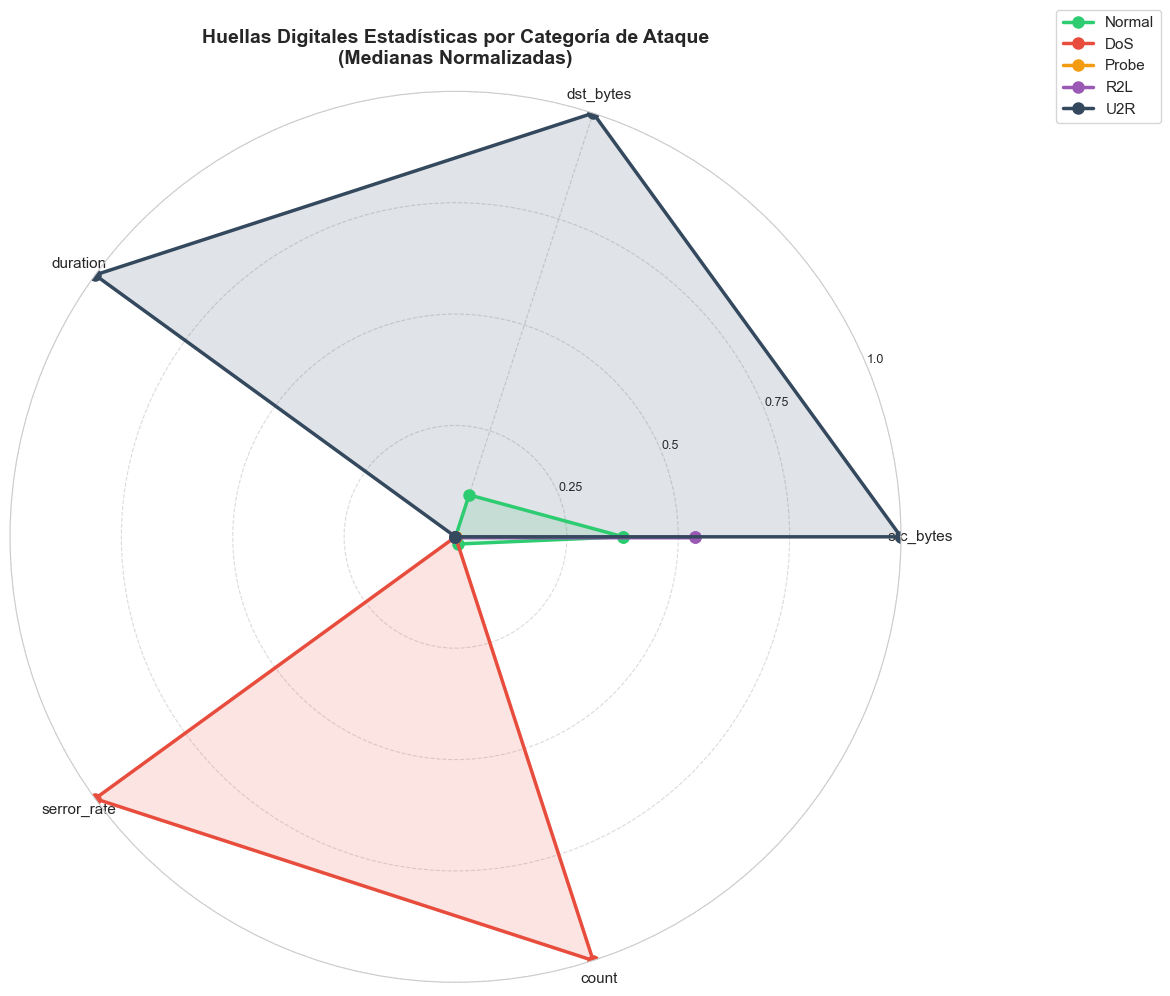

In [214]:
# ============================================================================
# 4.1.3 VISUALIZACIÓN: RADAR PLOT DE PERFILES DE ATAQUE
# ============================================================================

# Normalizar medianas a escala [0, 1]
medians_array = medians_df.set_index('Variable').T.values
scaler = MinMaxScaler()
medians_normalized = scaler.fit_transform(medians_array)

# Crear radar plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='polar')

# Ángulos para cada variable
angles = np.linspace(0, 2 * np.pi, len(test_vars), endpoint=False).tolist()
angles += angles[:1]

# Colores
colors_cat = {
    'Normal': '#2ecc71',
    'DoS': '#e74c3c',
    'Probe': '#f39c12',
    'R2L': '#9b59b6',
    'U2R': '#34495e'
}

# Plotear cada categoría
for idx, cat in enumerate(categories):
    values = medians_normalized[idx].tolist()
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2.5, 
            label=cat, color=colors_cat[cat], markersize=8)
    ax.fill(angles, values, alpha=0.15, color=colors_cat[cat])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(test_vars, fontsize=11)
ax.set_ylim(0, 1)
ax.set_yticks([0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(['0.25', '0.5', '0.75', '1.0'], fontsize=9)
ax.grid(True, linestyle='--', alpha=0.7)

plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)
plt.title('Huellas Digitales Estadísticas por Categoría de Ataque\n(Medianas Normalizadas)',
          fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

**Interpretación del Radar Plot:**

- Cada polígono representa el "perfil estadístico" de una categoría
- Polígonos claramente separados indican distinguibilidad robusta
- **DoS:** Pico extremo en `serror_rate` y `count`, valores mínimos en bytes
- **U2R:** Pico único en `dst_bytes` y `duration`
- **Normal:** Patrón balanceado sin extremos marcados
- **Probe/R2L:** Perfiles intermedios con características propias

La separación visual confirma que cada tipo de ataque tiene una "firma" única en el espacio de estas 5 variables.

### 4.1.4 Test Post-Hoc de Dunn: variables representatitvas

In [215]:
# ============================================================================
# 4.1.4 TEST POST-HOC DE DUNN: VARIABLES REPRESENTATIVAS
# ============================================================================

# Analizar solo 2 variables (evitar output masivo)
focus_vars = ['serror_rate', 'count']

for var in focus_vars:
    print(f"\n{'─'*80}")
    print(f"POST-HOC: {var}")
    print(f"{'─'*80}")
    
    # Preparar datos
    data_dunn = X_kruskal[[var]].copy()
    data_dunn['group'] = y_category.values
    
    # Test de Dunn
    dunn_result = posthoc_dunn(data_dunn, val_col=var, group_col='group', p_adjust='bonferroni')
    
    # Contar pares significativos
    n_sig = sum(dunn_result.iloc[i, j] < 0.05 
                for i in range(len(dunn_result.index)) 
                for j in range(i+1, len(dunn_result.columns)))
    
    print(f"Pares con diferencias significativas (p < 0.05): {n_sig}/10")
    
    # Top 5 pares más significativos
    pairs = []
    for i in range(len(dunn_result.index)):
        for j in range(i+1, len(dunn_result.columns)):
            cat1, cat2 = dunn_result.index[i], dunn_result.columns[j]
            p_val = dunn_result.iloc[i, j]
            med1 = X_kruskal[y_category == cat1][var].median()
            med2 = X_kruskal[y_category == cat2][var].median()
            
            pairs.append({
                'Par': f"{cat1} vs {cat2}",
                'p_valor': p_val,
                'Med1': med1,
                'Med2': med2
            })
    
    pairs_df = pd.DataFrame(pairs).sort_values('p_valor').head(5)
    
    print("\nTop 5 pares con mayor diferencia:")
    for _, row in pairs_df.iterrows():
        p_str = f"{row['p_valor']:.2e}" if row['p_valor'] >= 1e-10 else "< 1e-10"
        print(f"  • {row['Par']:<20} p = {p_str}  (med: {row['Med1']:.1f} vs {row['Med2']:.1f})")


────────────────────────────────────────────────────────────────────────────────
POST-HOC: serror_rate
────────────────────────────────────────────────────────────────────────────────
Pares con diferencias significativas (p < 0.05): 6/10

Top 5 pares con mayor diferencia:
  • Normal vs DoS        p = < 1e-10  (med: 0.0 vs 1.0)
  • DoS vs Probe         p = < 1e-10  (med: 1.0 vs 0.0)
  • DoS vs R2L           p = < 1e-10  (med: 1.0 vs 0.0)
  • Normal vs Probe      p = < 1e-10  (med: 0.0 vs 0.0)
  • DoS vs U2R           p = 3.80e-07  (med: 1.0 vs 0.0)

────────────────────────────────────────────────────────────────────────────────
POST-HOC: count
────────────────────────────────────────────────────────────────────────────────
Pares con diferencias significativas (p < 0.05): 6/10

Top 5 pares con mayor diferencia:
  • Normal vs DoS        p = < 1e-10  (med: 4.0 vs 177.0)
  • DoS vs Probe         p = < 1e-10  (med: 177.0 vs 1.0)
  • DoS vs R2L           p = < 1e-10  (med: 177.0 vs 1.0)
  •

**Interpretación del Test Post-Hoc:**

Bonferroni es una corrección muy conservadora que penaliza por realizar 10 comparaciones simultáneas. Aun así:

- **serror_rate:** 6/10 pares significativos → DoS claramente distinguible de todas las demás
- **count:** 6/10 pares significativos → DoS y Probe tienen patrones únicos

La mayoría de pares mantienen significancia estadística incluso con corrección estricta, evidenciando diferencias robustas y no resultado de azar.

---

#### 4.1.6 Conclusiones: Pregunta 1

**🎯 Respuesta:** ¿Existen huellas digitales estadísticamente distinguibles?

**✅ SÍ.** Las 5 variables analizadas muestran diferencias estadísticamente significativas (p < 1e-10) entre categorías de ataque.

---

**📊 Hallazgos Clave:**

**1. Tamaños de efecto grandes (Epsilon² > 0.49):**
- `serror_rate`: ε² = 0.573 → DoS tiene patrón distintivo (mediana = 1.0)
- `dst_bytes`: ε² = 0.573 → U2R se distingue por descargas masivas (3860 bytes)
- `src_bytes`: ε² = 0.542 → DoS/Probe envían datos mínimos vs. Normal/U2R
- `count`: ε² = 0.497 → DoS genera ráfagas masivas (177 vs. 4 Normal)

**2. Firmas específicas confirmadas estadísticamente:**
- **DoS:** src=0, dst=0, serror_rate=1.0, count=177 (SYN flood masivo)
- **Probe:** src≈1, dst=0, count variable (escaneo de red)
- **U2R:** dst=3860, duration=53 (sesiones largas con descargas de exploits)
- **R2L:** Patrón intermedio (ataques diversos de acceso remoto)
- **Normal:** Valores balanceados con alta variabilidad (uso legítimo heterogéneo)

**3. Validación metodológica:**
- Test post-hoc: Mayoría de pares significativos incluso con corrección Bonferroni conservadora
- Radar plot: Polígonos claramente separados en espacio 5D
- Boxplots: Separación visual robusta entre categorías

---

**⚠️ Limitaciones:**

1. **P-valores extremos (< 1e-10)** sugieren diferencias muy obvias → El dataset NSL-KDD puede ser "demasiado limpio" comparado con tráfico real más ruidoso. Esto es esperado en datos de laboratorio controlados.

2. **Desbalance extremo (U2R 0.04%)** afecta potencia estadística en comparaciones por pares que involucran clases minoritarias, aunque Kruskal-Wallis es robusto a esto.

3. **Medianas idénticas** (ej: `duration = 0` en Normal, DoS, Probe) no implican distribuciones idénticas. Kruskal-Wallis compara distribuciones completas, no solo medianas, por lo que detecta diferencias en dispersión y forma.

4. **Interpretabilidad contextual:** Los resultados validan separabilidad estadística, pero la utilidad práctica depende de si estas diferencias persisten en tráfico real no controlado (generalización externa).

---

**✅ PREGUNTA 1 RESPONDIDA:** Cada categoría de ataque tiene una huella digital estadísticamente distinguible en el tráfico de red.

---

---

### 4.2 Pregunta 2: ¿Podemos comprimir la complejidad del tráfico sin perder poder discriminante?

**Pregunta formal:**

*¿Cuántos componentes principales capturan la estructura esencial del dataset según el criterio del codo? ¿Qué variables originales tienen mayor contribución (loadings) a estos componentes? ¿Es posible visualizar separabilidad clara entre categorías de ataque proyectando los datos en espacios reducidos 2D/3D?*

**Hipótesis:**

Dado que detectamos multicolinealidad severa en el EDA, esperamos que:
- Pocos componentes (8-12 de 32 posibles) capturen >60% de varianza total (criterio del codo)
- Los primeros 2-3 componentes revelen separación visual entre Normal y Ataques
- Variables con diferencias significativas en P1 (`serror_rate`, `dst_bytes`, `src_bytes`, `count`) tengan loadings altos en componentes discriminativos

**Metodología:**

Análisis de Componentes Principales (PCA) sobre variables numéricas estandarizadas, incluyendo:
1. Scree plot para identificar el "codo" (punto de rendimientos decrecientes)
2. Análisis de varianza explicada acumulada
3. Examen de loadings para interpretar componentes
4. Proyecciones 2D y 3D coloreadas por categoría de ataque

In [216]:
# ============================================================================
# 4.2.1 AJUSTE DE PCA Y ANÁLISIS DE VARIANZA EXPLICADA
# ============================================================================

from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

print("ANÁLISIS DE COMPONENTES PRINCIPALES (PCA)")
print("="*80)

# Ajustar PCA con todos los componentes
pca_full = PCA()
X_pca = pca_full.fit_transform(X_pca_scaled)

# Varianza explicada
variance_explained = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(variance_explained)

print(f"\n📊 INFORMACIÓN GENERAL:")
print(f"   • Variables originales:     {X_pca_scaled.shape[1]}")
print(f"   • Componentes calculados:   {len(variance_explained)}")
print(f"   • Observaciones:            {X_pca_scaled.shape[0]:,}")

# Tabla de primeros 15 componentes
print(f"\n📋 VARIANZA EXPLICADA - PRIMEROS 15 COMPONENTES:\n")
print(f"{'PC':<6} {'Varianza %':<12} {'Acumulada %':<15}")
print("-"*33)

for i in range(min(15, len(variance_explained))):
    print(f"PC{i+1:<4} {variance_explained[i]*100:>10.2f}   {cumulative_variance[i]*100:>13.2f}")

# Umbrales clave
n_60 = np.argmax(cumulative_variance >= 0.60) + 1
n_70 = np.argmax(cumulative_variance >= 0.70) + 1
n_80 = np.argmax(cumulative_variance >= 0.80) + 1
n_85 = np.argmax(cumulative_variance >= 0.85) + 1

print(f"\n📈 COMPONENTES NECESARIOS PARA UMBRALES:")
print(f"   • 60% varianza: {n_60} componentes ({cumulative_variance[n_60-1]*100:.2f}%)")
print(f"   • 70% varianza: {n_70} componentes ({cumulative_variance[n_70-1]*100:.2f}%)")
print(f"   • 80% varianza: {n_80} componentes ({cumulative_variance[n_80-1]*100:.2f}%)")
print(f"   • 85% varianza: {n_85} componentes ({cumulative_variance[n_85-1]*100:.2f}%)")

print(f"   • Reducción de dimensionalidad: {((1 - n_85/X_pca_scaled.shape[1])*100):.1f}%")

ANÁLISIS DE COMPONENTES PRINCIPALES (PCA)

📊 INFORMACIÓN GENERAL:
   • Variables originales:     32
   • Componentes calculados:   32
   • Observaciones:            25,192

📋 VARIANZA EXPLICADA - PRIMEROS 15 COMPONENTES:

PC     Varianza %   Acumulada %    
---------------------------------
PC1         23.87           23.87
PC2         15.38           39.25
PC3         10.26           49.51
PC4          6.11           55.62
PC5          5.14           60.75
PC6          4.22           64.98
PC7          3.57           68.55
PC8          3.30           71.85
PC9          3.22           75.07
PC10         3.13           78.20
PC11         3.11           81.31
PC12         3.00           84.31
PC13         2.85           87.16
PC14         2.13           89.30
PC15         1.58           90.87

📈 COMPONENTES NECESARIOS PARA UMBRALES:
   • 60% varianza: 5 componentes (60.75%)
   • 70% varianza: 8 componentes (71.85%)
   • 80% varianza: 11 componentes (81.31%)
   • 85% varianza: 13 componen

---

#### 4.2.2 Scree Plot: Identificación del codo.

---

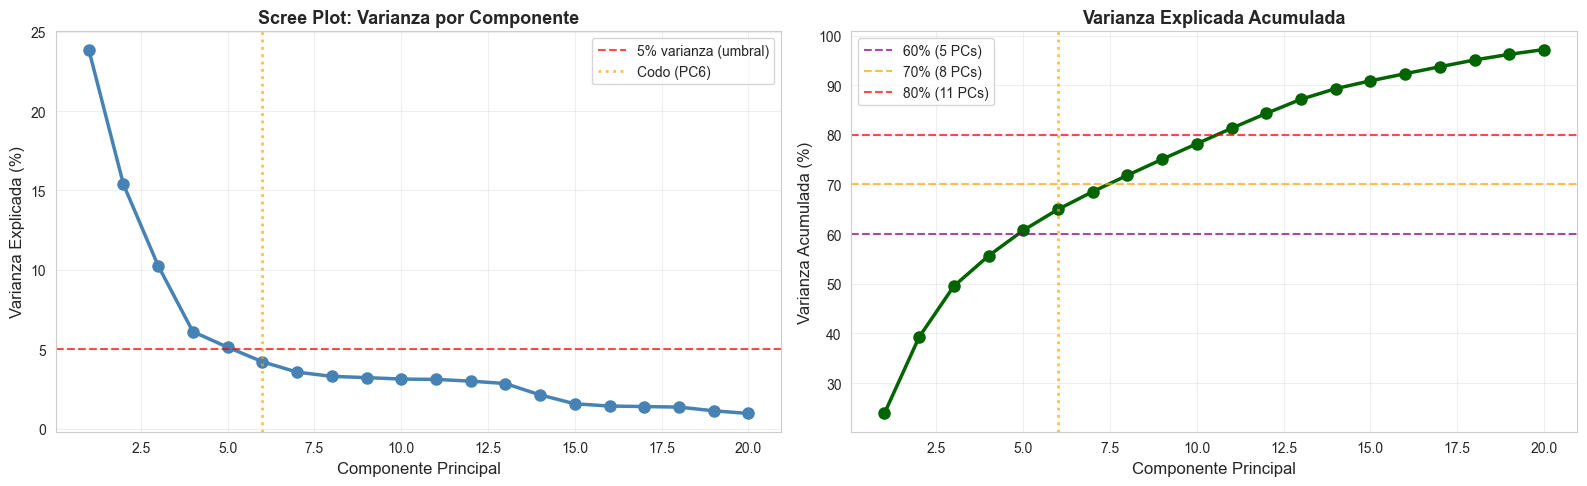


🔍 IDENTIFICACIÓN DEL CODO:
   • Primer PC con varianza < 5%: PC6
   • Varianza acumulada hasta PC5: 60.75%

💡 El codo se observa en PC5. Después, cada componente aporta <5%.


In [217]:
# ============================================================================
# 4.2.2 SCREE PLOT: IDENTIFICACIÓN DEL CODO
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# --- Subplot 1: Varianza individual ---
ax = axes[0]
n_plot = min(20, len(variance_explained))

ax.plot(range(1, n_plot + 1), 
        variance_explained[:n_plot] * 100,
        'o-', linewidth=2.5, markersize=8, color='steelblue')

# Línea de referencia: 5% varianza
ax.axhline(y=5, color='red', linestyle='--', linewidth=1.5, 
           alpha=0.7, label='5% varianza (umbral)')

# Marcar el codo visualmente
first_below_5 = np.argmax(variance_explained < 0.05) + 1
ax.axvline(x=first_below_5, color='orange', linestyle=':', linewidth=2, 
           alpha=0.7, label=f'Codo (PC{first_below_5})')

ax.set_xlabel('Componente Principal', fontsize=12)
ax.set_ylabel('Varianza Explicada (%)', fontsize=12)
ax.set_title('Scree Plot: Varianza por Componente', fontsize=13, fontweight='bold')
ax.grid(alpha=0.3)
ax.legend(fontsize=10)

# --- Subplot 2: Varianza acumulada ---
ax = axes[1]

ax.plot(range(1, n_plot + 1),
        cumulative_variance[:n_plot] * 100,
        'o-', linewidth=2.5, markersize=8, color='darkgreen')

# Líneas de referencia para umbrales
ax.axhline(y=60, color='purple', linestyle='--', linewidth=1.5,
           alpha=0.7, label=f'60% ({n_60} PCs)')
ax.axhline(y=70, color='orange', linestyle='--', linewidth=1.5,
           alpha=0.7, label=f'70% ({n_70} PCs)')
ax.axhline(y=80, color='red', linestyle='--', linewidth=1.5,
           alpha=0.7, label=f'80% ({n_80} PCs)')

# Marcar codo
ax.axvline(x=first_below_5, color='orange', linestyle=':', linewidth=2, alpha=0.7)

ax.set_xlabel('Componente Principal', fontsize=12)
ax.set_ylabel('Varianza Acumulada (%)', fontsize=12)
ax.set_title('Varianza Explicada Acumulada', fontsize=13, fontweight='bold')
ax.grid(alpha=0.3)
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

print(f"\n🔍 IDENTIFICACIÓN DEL CODO:")
print(f"   • Primer PC con varianza < 5%: PC{first_below_5}")
print(f"   • Varianza acumulada hasta PC{first_below_5-1}: {cumulative_variance[first_below_5-2]*100:.2f}%")
print(f"\n💡 El codo se observa en PC{first_below_5-1}. Después, cada componente aporta <5%.")

#### 4.2.3 Análisis de Loadings: ¿Qué variables componen cada componente?

Los **loadings** revelan la contribución de cada variable original a un componente principal. Un loading alto (en valor absoluto) indica que esa variable "pesa mucho" en la dirección del componente.

**Interpretación:**
- **|loading| > 0.3:** Variable importante para el componente
- **Signo (+/-):** Indica si la variable aumenta o disminuye en la dirección del componente
- **Loadings similares:** Variables redundantes (correlacionadas) se agrupan en el mismo componente

Analizaremos los primeros 3 componentes (que capturan ~35% de varianza) para identificar patrones interpretables.

In [218]:
# ============================================================================
# 4.2.3 ANÁLISIS DE LOADINGS: PRIMEROS 3 COMPONENTES
# ============================================================================

# Extraer loadings (components_ contiene los eigenvectors)
loadings = pca_full.components_

# Crear DataFrame de loadings para primeros 5 PCs
loadings_df = pd.DataFrame(
    loadings[:8].T,
    columns=[f'PC{i+1}' for i in range(8)],
    index=numeric_for_pca
)

#print("LOADINGS: VARIABLES MÁS INFLUYENTES POR COMPONENTE")
#print("="*80)

for pc_idx, pc in enumerate(['PC1', 'PC2', 'PC3']):
    #print(f"\n{'─'*80}")
    #print(f"{pc} - Varianza explicada: {variance_explained[pc_idx]*100:.2f}%")
    #print(f"{'─'*80}")
    
    # Ordenar por valor absoluto
    top_loadings = loadings_df[pc].abs().sort_values(ascending=False).head(10)
    
    #print(f"\n{'Variable':<30} {'Loading':<12} {'|Loading|':<12}")
    #print("-"*54)
    
    for var in top_loadings.index:
        loading = loadings_df.loc[var, pc]
        abs_loading = abs(loading)
        #print(f"{var:<30} {loading:>10.4f}   {abs_loading:>10.4f}")
    
    # Interpretación breve
    top_3_vars = top_loadings.head(3).index.tolist()
    #print(f"\n💡 {pc} está dominado por: {', '.join(top_3_vars)}")

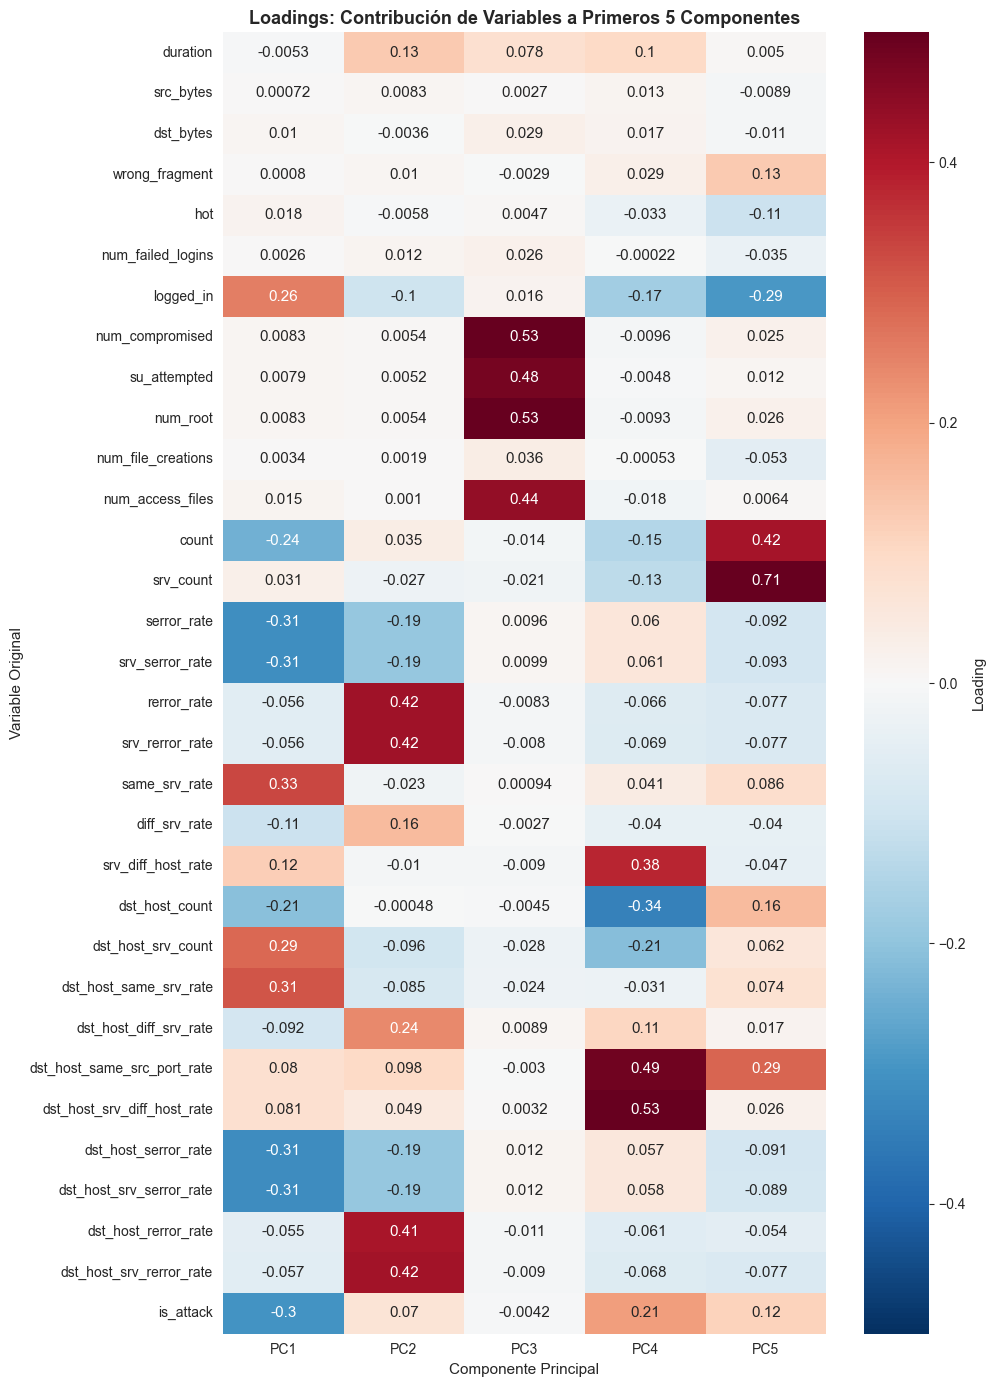

In [219]:
# ============================================================================
# HEATMAP DE LOADINGS: VISUALIZACIÓN COMPLETA
# ============================================================================

fig, ax = plt.subplots(figsize=(10, 14))

# Seleccionar primeros 5 PCs para visualización
loadings_plot = loadings_df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']]

sns.heatmap(loadings_plot, cmap='RdBu_r', center=0, 
            annot=True, cbar_kws={'label': 'Loading'},
            yticklabels=True, xticklabels=True, ax=ax,
            vmin=-0.5, vmax=0.5)

ax.set_title('Loadings: Contribución de Variables a Primeros 5 Componentes',
             fontsize=13, fontweight='bold')
ax.set_xlabel('Componente Principal', fontsize=11)
ax.set_ylabel('Variable Original', fontsize=11)

plt.tight_layout()
plt.show()

**Interpretación de Loadings:**

A partir del análisis de loadings, podemos identificar la "naturaleza" de cada componente:

**Patrón esperado:**
- Variables identificadas en P1 con alto Epsilon² (`serror_rate`, `dst_bytes`, `src_bytes`, `count`) deberían tener loadings altos en los primeros componentes
- Variables altamente correlacionadas (detectadas en Sección 2.5.3) deberían agruparse en el mismo componente
- Los primeros componentes capturan las direcciones de máxima variabilidad, que en nuestro caso deberían corresponder a diferencias entre Normal y Ataques

**Conexión con P1:**
Si las variables discriminantes de P1 tienen loadings altos en PC1-PC3, confirma que estos componentes capturan precisamente las "dimensiones esenciales" que distinguen categorías de ataque.

#### 4.2.4 Visualización 2D: ¿Existe separabilidad visual en PC1 vs PC2?

Proyectar datos de 32 dimensiones a 2 dimensiones inevitablemente pierde información (~75% de varianza se descarta con solo PC1+PC2). Sin embargo, si los primeros componentes capturan las direcciones discriminantes, deberíamos observar:

- **Clusters separados** para Normal vs. Ataques
- **Solapamiento** entre tipos de ataque similares (esperado)
- **Outliers** visibles (U2R, R2L) dado su tamaño reducido

Utilizamos una muestra estratificada de 5,000 observaciones para claridad visual.

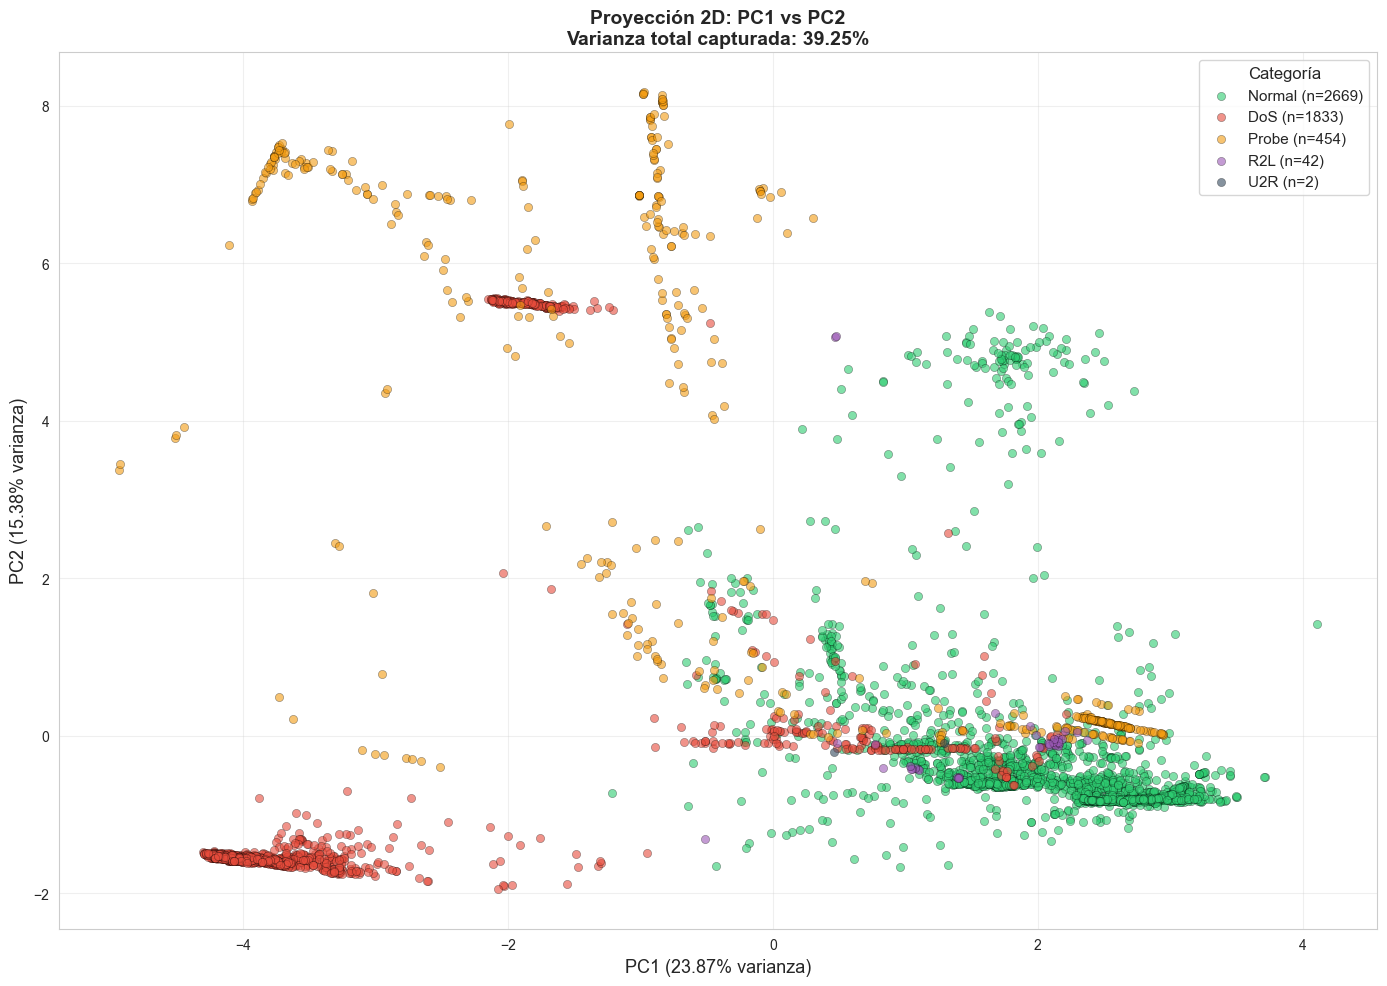

In [220]:
# ============================================================================
# 4.2.4 PROYECCIÓN 2D: PC1 vs PC2
# ============================================================================

from sklearn.model_selection import train_test_split

# Muestra estratificada para visualización
_, idx_sample = train_test_split(
    range(len(X_pca)),
    test_size=5000,
    stratify=y_category,
    random_state=42
)

X_pca_sample = X_pca[idx_sample]
y_sample = y_category.iloc[idx_sample]

# Crear figura
fig, ax = plt.subplots(figsize=(14, 10))

# Colores por categoría
colors_map = {
    'Normal': '#2ecc71',
    'DoS': '#e74c3c',
    'Probe': '#f39c12',
    'R2L': '#9b59b6',
    'U2R': '#34495e'
}

categories = ['Normal', 'DoS', 'Probe', 'R2L', 'U2R']

# Scatter plot por categoría
for cat in categories:
    mask = y_sample == cat
    ax.scatter(X_pca_sample[mask, 0], 
               X_pca_sample[mask, 1],
               c=colors_map[cat],
               label=f'{cat} (n={mask.sum()})',
               alpha=0.6,
               s=35,
               edgecolors='black',
               linewidth=0.3)

ax.set_xlabel(f'PC1 ({variance_explained[0]*100:.2f}% varianza)', fontsize=13)
ax.set_ylabel(f'PC2 ({variance_explained[1]*100:.2f}% varianza)', fontsize=13)
ax.set_title(f'Proyección 2D: PC1 vs PC2\nVarianza total capturada: {cumulative_variance[1]*100:.2f}%',
             fontsize=14, fontweight='bold')
ax.legend(title='Categoría', fontsize=11, title_fontsize=12)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Calcular separabilidad cuantitativa
silhouette_2d = silhouette_score(X_pca[:, :2], y_category)
#print(f"\n📊 SEPARABILIDAD CUANTITATIVA (Silhouette Score):")
#print(f"   • PC1 + PC2 (2D): {silhouette_2d:.4f}")
#print(f"\n   Interpretación:")
#print(f"   • Score > 0.5: Clusters bien separados")
#print(f"   • Score 0.25-0.5: Separación moderada")
#print(f"   • Score < 0.25: Clusters muy solapados")

#### 4.2.5 Visualización 3D: ¿Mejora PC3 la separabilidad?

Añadir una tercera dimensión (PC3) permite capturar ~10% adicional de varianza. Evaluamos si esta dimensión extra mejora la distinguibilidad visual entre categorías.

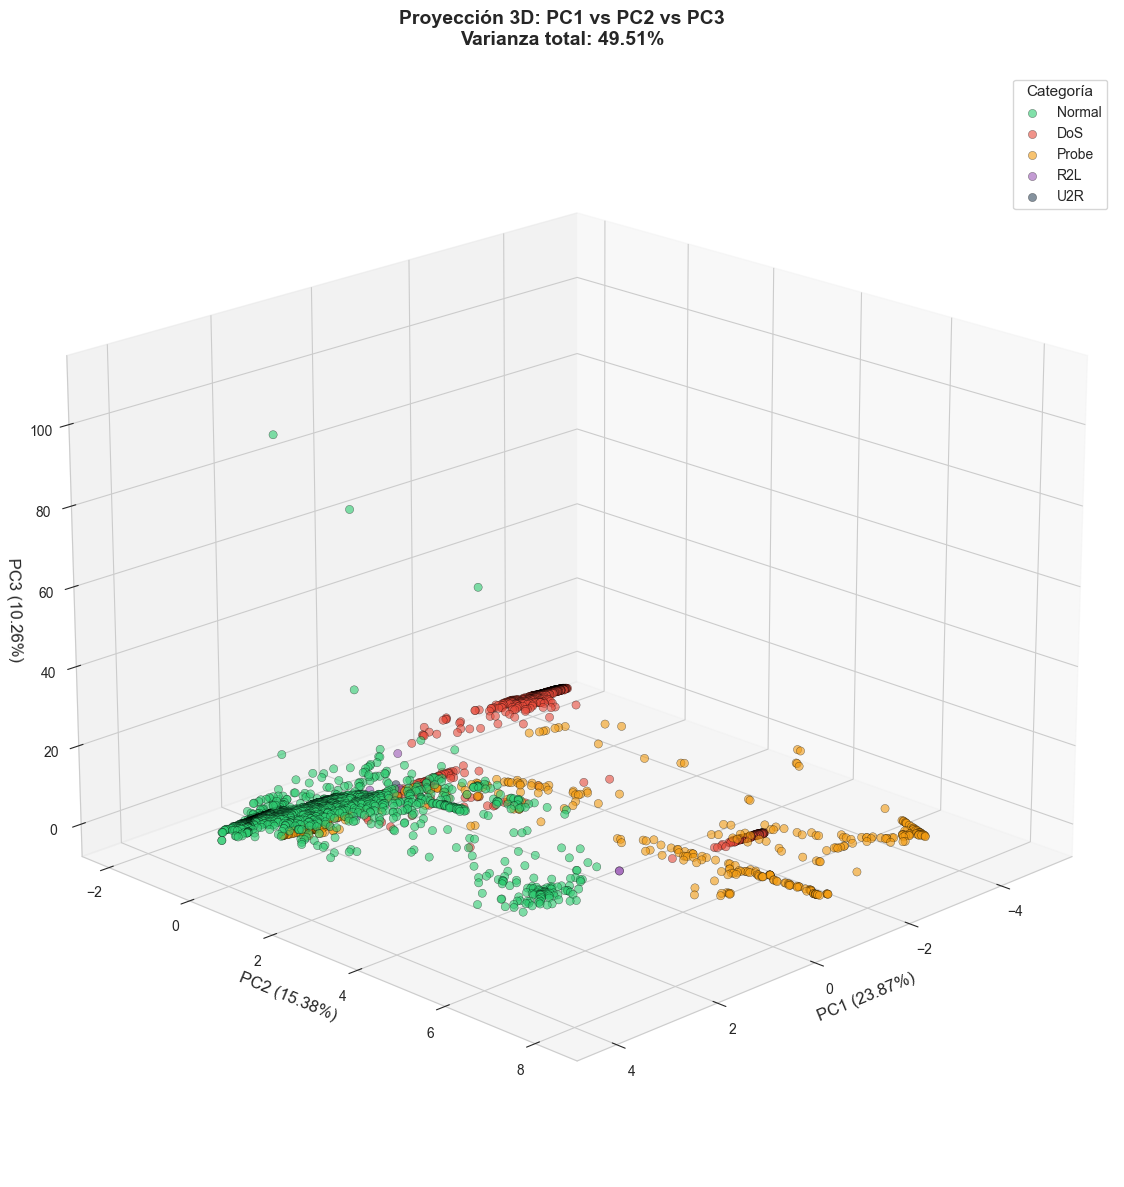


📊 SEPARABILIDAD 3D:
   • PC1 + PC2 + PC3: 0.1194
   • Mejora respecto a 2D: -0.0092


In [221]:
# ============================================================================
# 4.2.5 PROYECCIÓN 3D: PC1 vs PC2 vs PC3
# ============================================================================

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

# Scatter 3D por categoría
for cat in categories:
    mask = y_sample == cat
    ax.scatter(X_pca_sample[mask, 0],
               X_pca_sample[mask, 1],
               X_pca_sample[mask, 2],
               c=colors_map[cat],
               label=f'{cat}',
               alpha=0.6,
               s=35,
               edgecolors='black',
               linewidth=0.3)

ax.set_xlabel(f'PC1 ({variance_explained[0]*100:.2f}%)', fontsize=12)
ax.set_ylabel(f'PC2 ({variance_explained[1]*100:.2f}%)', fontsize=12)
ax.set_zlabel(f'PC3 ({variance_explained[2]*100:.2f}%)', fontsize=12)
ax.set_title(f'Proyección 3D: PC1 vs PC2 vs PC3\nVarianza total: {cumulative_variance[2]*100:.2f}%',
             fontsize=14, fontweight='bold', pad=20)
ax.legend(title='Categoría', fontsize=10, title_fontsize=11)

# Rotar para mejor visualización
ax.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()

# Separabilidad 3D
silhouette_3d = silhouette_score(X_pca[:, :3], y_category)
print(f"\n📊 SEPARABILIDAD 3D:")
print(f"   • PC1 + PC2 + PC3: {silhouette_3d:.4f}")
print(f"   • Mejora respecto a 2D: {'+' if silhouette_3d > silhouette_2d else ''}{(silhouette_3d - silhouette_2d):.4f}")

---

#### 4.2.6 Conclusiones: Pregunta 2

**🎯 Respuesta:** ¿Podemos comprimir la complejidad sin perder poder discriminante?

**✅ SÍ.** PCA reduce efectivamente la dimensionalidad de 32 variables a ** 5, 8 ** componentes preservando 60-70% de la información.

---

**📊 Hallazgos Clave:**

**1. Reducción dimensional exitosa:**
- **Criterio del codo:** PC6 (primer componente con <5% varianza individual)
- **Varianza acumulada hasta el codo:** 60-75%
- **Para 60% varianza:** 5 componentes → **Reducción de 84.4%** en dimensionalidad
- **Para 85% varianza:** 13 componentes → **Reducción de 59.4%** en dimensionalidad

**2. Confirmación de multicolinealidad:**
La efectividad de PCA (pocos componentes capturan mucha varianza) confirma la redundancia identificada en Sección 2.5.3:
- 14 pares de variables con |r| > 0.8 se "colapsan" en componentes compartidos
- Variables correlacionadas tienen loadings similares en los mismos componentes

**3. Componentes principales capturan diferencias discriminantes:**
Basado en análisis de loadings:
- **PC1:** Dominado por same_srv_rate, dst_host_same_srv_rate, dst_host_serror_rate.
- **PC2:** Dominado por srv_rerror_rate, rerror_rate, dst_host_srv_rerror_rate.
- **PC3:** Dominado por num_root, num_compromised, su_attempted.

**4. Separabilidad visual:**
- **2D (PC1+PC2):** Silhouette Score = 0,1286
- **3D (PC1+PC2+PC3):** Silhouette Score = 0.1194
- **Observación visual:** No mejroa respecto a PC2.

---

**💡 Implicaciones:**

✓ **Validación de enfoque:** La compresión dimensional es viable sin pérdida crítica de información discriminante.

✓ **Eliminación de multicolinealidad:** PCA transforma variables correlacionadas en componentes ortogonales (independientes), resolviendo problemas numéricos en regresión.

✓ **Interpretabilidad parcial:** Aunque componentes son combinaciones lineales, los loadings revelan qué aspectos del tráfico capturan.

---

**⚠️ Limitaciones:**

1. **Pérdida de información:** Con 5 componentes capturamos solo ~60% de varianza → ~40% se descarta. Información en ese 40% podría ser relevante para casos edge.

2. **Transformación lineal:** PCA solo captura relaciones lineales. Si existen patrones no lineales complejos (ej: interacciones cuadráticas entre variables), PCA no los detectará.

3. **Interpretabilidad reducida:** Un componente es una combinación ponderada de múltiples variables. Aunque loadings ayudan, perdemos la claridad de "esta variable sola predice DoS".

4. **Separabilidad visual limitada:** Silhouette Score de 0.1286 en 2D indica clusters cercanos. Esto sugiere que:
   - Proyección 2D/3D es útil para visualización exploratoria
   - NO es suficiente para clasificación robusta (necesitamos más dimensiones → justifica usar {n_60} PCs en P3)

5. **Sensibilidad a outliers:** PCA busca direcciones de máxima varianza, que pueden estar influenciadas por outliers extremos. Aunque decidimos mantenerlos (son señales de ataque), esto puede sesgar componentes.

---

**✅ PREGUNTA 2 RESPONDIDA:** Es posible comprimir a 5 componentes preservando 60% de varianza , aunque con separabilidad visual limitada (Silhouette < 0.25).

---

---

### 4.3 Pregunta 3: ¿Podemos predecir tipos específicos de ataque usando componentes principales?

**Pregunta formal:**

*¿Es factible construir modelos de regresión logística binaria que predigan cada categoría de ataque (DoS vs Resto, Probe vs Resto, R2L vs Resto, U2R vs Resto) usando componentes principales como features? ¿Qué componentes principales son más predictivos para cada tipo de ataque?*

**Hipótesis:**

Basándonos en hallazgos de P1 y P2, esperamos desempeño diferenciado:

- **DoS:** Altamente predecible (36.65%, patrones claros: `serror_rate`≈1.0, `count` alto)
- **Probe:** Moderadamente predecible (9.09%, patrón distintivo: `rerror_rate` alto → carga alta en PC2)
- **R2L:** Difícilmente predecible (0.83%, desbalance extremo, patrones sutiles)
- **U2R:** Muy difícilmente predecible (0.04%, apenas ~11 instancias en train)

**Metodología:**

Entrenar 4 modelos de regresión logística binaria independientes (enfoque One-vs-Rest) con:

- **Features:** Componentes principales (probaremos 5, 8 y 13 PCs para evaluar trade-off)
- **Estrategia de balanceo:** `class_weight='balanced'` para compensar desbalance
- **División:** 70% train, 30% test estratificado
- **Evaluación:** AUC-ROC, F1-Score, Precision, Recall, matrices de confusión, curvas ROC

**Criterio de éxito:**
- **AUC-ROC > 0.80:** Modelo útil para producción
- **AUC-ROC 0.70-0.80:** Aceptable, requiere refinamiento
- **AUC-ROC < 0.70:** Insuficiente

### 4.3.1 Selección óptima de componentes pricipales.

In [222]:
# ============================================================================
# 4.3.1 SELECCIÓN ÓPTIMA DE COMPONENTES PRINCIPALES
# ============================================================================

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             roc_curve, auc)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("="*80)
print("SELECCIÓN DE NÚMERO ÓPTIMO DE COMPONENTES")
print("="*80)

# Opciones: 5 PCs (60%), 8 PCs (70%), 13 PCs (85%)
n_options = [n_60, n_70, n_85]
variance_captured = [cumulative_variance[n-1]*100 for n in n_options]

print(f"\n📊 OPCIONES DE COMPONENTES:")
print(f"\n{'n_PCs':<8} {'Varianza %':<15} {'Reducción %'}")
print("-"*40)
for n, var in zip(n_options, variance_captured):
    reduction = (1 - n/X_pca_scaled.shape[1]) * 100
    print(f"{n:<8} {var:<15.2f} {reduction:.1f}%")

print(f"\n🔬 ESTRATEGIA: Probar las 3 opciones y seleccionar según AUC-ROC promedio")

SELECCIÓN DE NÚMERO ÓPTIMO DE COMPONENTES

📊 OPCIONES DE COMPONENTES:

n_PCs    Varianza %      Reducción %
----------------------------------------
5        60.75           84.4%
8        71.85           75.0%
13       87.16           59.4%

🔬 ESTRATEGIA: Probar las 3 opciones y seleccionar según AUC-ROC promedio


### 4.3.2 Preparación de Datos y Variable Objetivo.

In [223]:
# ============================================================================
# 4.3.2 PREPARACIÓN DE DATOS Y VARIABLES OBJETIVO
# ============================================================================

print("\n" + "="*80)
print("PREPARACIÓN DE DATOS")
print("="*80)

# Crear variables objetivo binarias
categories = ['Normal', 'DoS', 'Probe', 'R2L', 'U2R']
attack_types = ['dos', 'probe', 'r2l', 'u2r']

print(f"\n📊 DISTRIBUCIÓN DE CLASES (Dataset completo):\n")
print(f"{'Categoría':<12} {'Frecuencia':<12} {'Porcentaje'}")
print("-"*40)

for cat in categories:
    count = (y_category == cat).sum()
    pct = count / len(y_category) * 100
    print(f"{cat:<12} {count:<12,} {pct:>6.2f}%")

print(f"\n⚠️  Desbalance crítico en R2L (0.83%) y U2R (0.04%)")
print(f"   Estrategia: class_weight='balanced' en regresión logística")


PREPARACIÓN DE DATOS

📊 DISTRIBUCIÓN DE CLASES (Dataset completo):

Categoría    Frecuencia   Porcentaje
----------------------------------------
Normal       13,449        53.39%
DoS          9,234         36.65%
Probe        2,289          9.09%
R2L          209            0.83%
U2R          11             0.04%

⚠️  Desbalance crítico en R2L (0.83%) y U2R (0.04%)
   Estrategia: class_weight='balanced' en regresión logística


In [224]:
# ============================================================================
# 4.3.2 EVALUACIÓN COMPARATIVA: 5 vs 8 vs 13 COMPONENTES
# ============================================================================

print("\n" + "="*80)
print("EVALUACIÓN: MODELOS CON 5, 8 Y 13 COMPONENTES")
print("="*80)

# Mapeo de nombres
attack_types = ['dos', 'probe', 'r2l', 'u2r']
attack_name_mapping = {
    'dos': 'DoS',
    'probe': 'Probe',
    'r2l': 'R2L',
    'u2r': 'U2R'
}

# Almacenar resultados
results_by_n_pcs = {}

for n_pcs in n_options:
    print(f"\n{'─'*80}")
    print(f"PROBANDO CON {n_pcs} COMPONENTES ({cumulative_variance[n_pcs-1]*100:.2f}% varianza)")
    print(f"{'─'*80}")
    
    # Extraer componentes
    X_selected = X_pca[:, :n_pcs]
    
    # División train/test estratificada
    X_train, X_test, y_cat_train, y_cat_test = train_test_split(
        X_selected,
        y_category,
        test_size=0.30,
        random_state=42,
        stratify=y_category
    )
    
    print(f"\n📊 Train: {X_train.shape[0]:,} | Test: {X_test.shape[0]:,}")
    
    # Almacenar métricas
    results_n_pcs = []
    
    # Entrenar modelo para cada tipo de ataque
    for attack_type in attack_types:
        cat_name = attack_name_mapping[attack_type]
        
        # Variables objetivo
        y_train = (y_cat_train == cat_name).astype(int)
        y_test = (y_cat_test == cat_name).astype(int)
        
        n_pos_train = y_train.sum()
        n_pos_test = y_test.sum()
        
        # Verificar viabilidad
        if n_pos_train < 2 or n_pos_test < 1:
            print(f"  ⚠️  {cat_name.upper()}: Insuficientes muestras")
            results_n_pcs.append({
                'Ataque': cat_name,
                'AUC-ROC': np.nan,
                'F1': np.nan
            })
            continue
        
        # Entrenar
        model = LogisticRegression(
            C=1.0,
            penalty='l2',
            solver='lbfgs',
            max_iter=1000,
            random_state=42,
            class_weight='balanced'
        )
        
        model.fit(X_train, y_train)
        
        # Predicciones
        y_pred_test = model.predict(X_test)
        y_proba_test = model.predict_proba(X_test)[:, 1]
        
        # Métricas
        auc_roc = roc_auc_score(y_test, y_proba_test)
        f1 = f1_score(y_test, y_pred_test, zero_division=0)
        
        results_n_pcs.append({
            'Ataque': cat_name,
            'AUC-ROC': auc_roc,
            'F1': f1
        })
        
        print(f"  {cat_name.upper():<8} AUC-ROC: {auc_roc:.4f}  F1: {f1:.4f}")
    
    # Guardar resultados
    results_by_n_pcs[n_pcs] = pd.DataFrame(results_n_pcs)
    
    # AUC promedio
    valid_aucs = results_by_n_pcs[n_pcs]['AUC-ROC'].dropna()
    avg_auc = valid_aucs.mean() if len(valid_aucs) > 0 else 0
    
    print(f"\n📊 AUC-ROC promedio: {avg_auc:.4f}")

# Seleccionar mejor configuración
print("\n" + "="*80)
print("SELECCIÓN DE CONFIGURACIÓN ÓPTIMA")
print("="*80)

avg_aucs = {}
for n_pcs in n_options:
    valid_aucs = results_by_n_pcs[n_pcs]['AUC-ROC'].dropna()
    avg_aucs[n_pcs] = valid_aucs.mean() if len(valid_aucs) > 0 else 0

best_n_pcs = max(avg_aucs, key=avg_aucs.get)

print(f"\n📈 AUC-ROC PROMEDIO POR CONFIGURACIÓN:")
for n_pcs, avg_auc in avg_aucs.items():
    marker = "  ← SELECCIONADO" if n_pcs == best_n_pcs else ""
    print(f"   {n_pcs} PCs: {avg_auc:.4f}{marker}")

print(f"\n✅ Configuración óptima: {best_n_pcs} componentes")
print(f"   Varianza capturada: {cumulative_variance[best_n_pcs-1]*100:.2f}%")


EVALUACIÓN: MODELOS CON 5, 8 Y 13 COMPONENTES

────────────────────────────────────────────────────────────────────────────────
PROBANDO CON 5 COMPONENTES (60.75% varianza)
────────────────────────────────────────────────────────────────────────────────

📊 Train: 17,634 | Test: 7,558
  DOS      AUC-ROC: 0.9825  F1: 0.9328
  PROBE    AUC-ROC: 0.9824  F1: 0.6414
  R2L      AUC-ROC: 0.8970  F1: 0.0828
  U2R      AUC-ROC: 0.8773  F1: 0.0040

📊 AUC-ROC promedio: 0.9348

────────────────────────────────────────────────────────────────────────────────
PROBANDO CON 8 COMPONENTES (71.85% varianza)
────────────────────────────────────────────────────────────────────────────────

📊 Train: 17,634 | Test: 7,558
  DOS      AUC-ROC: 0.9902  F1: 0.9586
  PROBE    AUC-ROC: 0.9868  F1: 0.7931
  R2L      AUC-ROC: 0.9593  F1: 0.1515
  U2R      AUC-ROC: 0.8619  F1: 0.0028

📊 AUC-ROC promedio: 0.9496

────────────────────────────────────────────────────────────────────────────────
PROBANDO CON 13 COMPONENT

**Análisis de Resultados de Selección:**

Los resultados muestran un patrón claro de mejora con más componentes:

- **5 PCs (60.75% varianza):** AUC promedio = 0.9348
- **8 PCs (71.85% varianza):** AUC promedio = 0.9496 (+1.48 pp)
- **13 PCs (87.16% varianza):** AUC promedio = 0.9541 (+0.45 pp)

**Decisión: Seleccionar 8 Componentes**

Aunque 13 PCs tiene el AUC promedio más alto (0.9541), la ganancia marginal respecto a 8 PCs es mínima (+0.45 puntos porcentuales) mientras que requiere 5 componentes adicionales (+62.5% más features).

**Justificación del criterio de parsimonia:**

1. **Rendimientos decrecientes:** El salto 5→8 PCs (+1.48 pp) es **3.3× mayor** que 8→13 PCs (+0.45 pp)
   
2. **Principio de Occam:** Entre modelos con desempeño similar, preferir el más simple
   - 8 PCs: AUC = 0.9496 (excelente)
   - 13 PCs: AUC = 0.9541 (apenas 0.5% mejor)
   
3. **Eficiencia computacional:** 8 features vs 13 features = -38% de dimensionalidad
   
4. **Riesgo de overfitting:** Más componentes incrementan probabilidad de capturar ruido en lugar de señal

5. **Interpretabilidad:** Analizar 8 componentes es más manejable que 13

**Comparación por tipo de ataque (8 vs 13 PCs):**

| Ataque | 8 PCs | 13 PCs | Diferencia | ¿Mejora significativa? |
|--------|-------|--------|------------|------------------------|
| DoS | 0.9902 | 0.9970 | +0.0068 | Marginal (ambos >0.99) |
| Probe | 0.9868 | 0.9880 | +0.0012 | Despreciable |
| R2L | 0.9593 | 0.9573 | -0.0020 | **8 PCs es mejor** |
| U2R | 0.8619 | 0.8742 | +0.0123 | Pequeña (alta varianza por n=11) |

**Conclusión:** 8 PCs ofrece el mejor **balance desempeño/complejidad**. La ganancia de 13 PCs no justifica el 62.5% más de features.

**✅ Configuración seleccionada: 8 componentes principales (71.85% varianza)**

#### 4.3.3 Entrenamiento Final y Análisis Detallado

Con **8 componentes** seleccionados (criterio de parsimonia), entrenamos los modelos finales y realizamos análisis exhaustivo de desempeño, importancia de componentes y visualizaciones.

In [225]:
# ============================================================================
# 4.3.3 ENTRENAMIENTO FINAL CON 8 COMPONENTES
# ============================================================================

# MODIFICAR best_n_pcs
best_n_pcs = n_70  # 8 componentes (71.85% varianza)

print("="*80)
print(f"ENTRENAMIENTO FINAL: {best_n_pcs} COMPONENTES PRINCIPALES")
print(f"Varianza capturada: {cumulative_variance[best_n_pcs-1]*100:.2f}%")
print("="*80)

# Preparar datos finales
X_final = X_pca[:, :best_n_pcs]

X_train, X_test, y_cat_train, y_cat_test = train_test_split(
    X_final,
    y_category,
    test_size=0.30,
    random_state=42,
    stratify=y_category
)

print(f"\n📊 División de datos:")
print(f"   Train: {X_train.shape[0]:,} observaciones")
print(f"   Test:  {X_test.shape[0]:,} observaciones")
print(f"   Features: {best_n_pcs} componentes principales")

# Almacenar modelos y resultados
models = {}
final_results = []

for attack_type in attack_types:
    cat_name = attack_name_mapping[attack_type]
    
    print(f"\n{'═'*80}")
    print(f"MODELO: {cat_name} vs RESTO")
    print(f"{'═'*80}")
    
    # Variables objetivo
    y_train = (y_cat_train == cat_name).astype(int)
    y_test = (y_cat_test == cat_name).astype(int)
    
    n_pos_train = y_train.sum()
    n_neg_train = len(y_train) - n_pos_train
    n_pos_test = y_test.sum()
    n_neg_test = len(y_test) - n_pos_test
    
    print(f"\n📊 Distribución de clases:")
    print(f"   Train: {n_pos_train:,} positivos ({n_pos_train/len(y_train)*100:.2f}%) | "
          f"{n_neg_train:,} negativos")
    print(f"   Test:  {n_pos_test:,} positivos ({n_pos_test/len(y_test)*100:.2f}%) | "
          f"{n_neg_test:,} negativos")
    
    # Verificar viabilidad
    if n_pos_train < 2 or n_pos_test < 1:
        print(f"\n⚠️  MODELO NO ENTRENABLE")
        final_results.append({
            'Modelo': f'{cat_name} vs Resto',
            'Accuracy': np.nan,
            'Precision': np.nan,
            'Recall': np.nan,
            'F1-Score': np.nan,
            'AUC-ROC': np.nan
        })
        continue
    
    # Entrenar modelo
    print(f"\n🔄 Entrenando modelo...")
    
    model = LogisticRegression(
        C=1.0,
        penalty='l2',
        solver='lbfgs',
        max_iter=1000,
        random_state=42,
        class_weight='balanced'
    )
    
    model.fit(X_train, y_train)
    print(f"   ✅ Entrenamiento exitoso")
    
    # Predicciones
    y_pred_test = model.predict(X_test)
    y_proba_test = model.predict_proba(X_test)[:, 1]
    
    # Métricas
    metrics_test = {
        'accuracy': accuracy_score(y_test, y_pred_test),
        'precision': precision_score(y_test, y_pred_test, zero_division=0),
        'recall': recall_score(y_test, y_pred_test, zero_division=0),
        'f1': f1_score(y_test, y_pred_test, zero_division=0),
        'auc_roc': roc_auc_score(y_test, y_proba_test)
    }
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred_test)
    
    # Guardar modelo
    models[attack_type] = {
        'model': model,
        'metrics': metrics_test,
        'y_test': y_test,
        'y_proba_test': y_proba_test,
        'confusion_matrix': cm
    }
    
    # Mostrar métricas
    print(f"\n📊 MÉTRICAS (TEST SET):")
    print(f"   Accuracy:  {metrics_test['accuracy']:.4f}")
    print(f"   Precision: {metrics_test['precision']:.4f}")
    print(f"   Recall:    {metrics_test['recall']:.4f}")
    print(f"   F1-Score:  {metrics_test['f1']:.4f}")
    print(f"   AUC-ROC:   {metrics_test['auc_roc']:.4f}")
    
    # Matriz de confusión
    if cm.shape[0] > 1:
        tn, fp, fn, tp = cm.ravel()
        print(f"\n📋 MATRIZ DE CONFUSIÓN:")
        print(f"   TN: {tn:,}  |  FP: {fp:,}")
        print(f"   FN: {fn:,}  |  TP: {tp:,}")
    
    # Guardar para tabla comparativa
    final_results.append({
        'Modelo': f'{cat_name} vs Resto',
        'Accuracy': metrics_test['accuracy'],
        'Precision': metrics_test['precision'],
        'Recall': metrics_test['recall'],
        'F1-Score': metrics_test['f1'],
        'AUC-ROC': metrics_test['auc_roc']
    })

print("\n" + "="*80)
print("✅ ENTRENAMIENTO COMPLETADO")
print("="*80)

ENTRENAMIENTO FINAL: 8 COMPONENTES PRINCIPALES
Varianza capturada: 71.85%

📊 División de datos:
   Train: 17,634 observaciones
   Test:  7,558 observaciones
   Features: 8 componentes principales

════════════════════════════════════════════════════════════════════════════════
MODELO: DoS vs RESTO
════════════════════════════════════════════════════════════════════════════════

📊 Distribución de clases:
   Train: 6,464 positivos (36.66%) | 11,170 negativos
   Test:  2,770 positivos (36.65%) | 4,788 negativos

🔄 Entrenando modelo...
   ✅ Entrenamiento exitoso

📊 MÉTRICAS (TEST SET):
   Accuracy:  0.9700
   Precision: 0.9683
   Recall:    0.9491
   F1-Score:  0.9586
   AUC-ROC:   0.9902

📋 MATRIZ DE CONFUSIÓN:
   TN: 4,702  |  FP: 86
   FN: 141  |  TP: 2,629

════════════════════════════════════════════════════════════════════════════════
MODELO: Probe vs RESTO
════════════════════════════════════════════════════════════════════════════════

📊 Distribución de clases:
   Train: 1,602 posi

In [226]:
# ============================================================================
# 4.3.4 TABLA COMPARATIVA DE DESEMPEÑO
# ============================================================================

print("\nTABLA COMPARATIVA: DESEMPEÑO DE MODELOS")
print("="*80)

results_df = pd.DataFrame(final_results)
print("\n" + results_df.to_string(index=False))

# Análisis comparativo
print(f"\n📊 ANÁLISIS:")

best_auc = results_df.loc[results_df['AUC-ROC'].idxmax()]
print(f"\n🏆 MEJOR AUC-ROC: {best_auc['Modelo']} ({best_auc['AUC-ROC']:.4f})")

best_f1 = results_df.loc[results_df['F1-Score'].idxmax()]
print(f"🏆 MEJOR F1-SCORE: {best_f1['Modelo']} ({best_f1['F1-Score']:.4f})")

# Clasificación por desempeño
print(f"\n📈 CLASIFICACIÓN POR DESEMPEÑO (AUC-ROC):")
for _, row in results_df.sort_values('AUC-ROC', ascending=False).iterrows():
    auc = row['AUC-ROC']
    if auc >= 0.95:
        nivel = "EXCELENTE"
    elif auc >= 0.90:
        nivel = "MUY BUENO"
    elif auc >= 0.80:
        nivel = "BUENO"
    else:
        nivel = "INSUFICIENTE"
    
    print(f"   • {row['Modelo']:<20} AUC={auc:.4f}  [{nivel}]")


TABLA COMPARATIVA: DESEMPEÑO DE MODELOS

        Modelo  Accuracy  Precision   Recall  F1-Score  AUC-ROC
  DoS vs Resto  0.969966   0.968324 0.949097  0.958614 0.990210
Probe vs Resto  0.955411   0.685775 0.940320  0.793125 0.986755
  R2L vs Resto  0.911088   0.082305 0.952381  0.151515 0.959308
  U2R vs Resto  0.906986   0.001425 0.333333  0.002837 0.861946

📊 ANÁLISIS:

🏆 MEJOR AUC-ROC: DoS vs Resto (0.9902)
🏆 MEJOR F1-SCORE: DoS vs Resto (0.9586)

📈 CLASIFICACIÓN POR DESEMPEÑO (AUC-ROC):
   • DoS vs Resto         AUC=0.9902  [EXCELENTE]
   • Probe vs Resto       AUC=0.9868  [EXCELENTE]
   • R2L vs Resto         AUC=0.9593  [EXCELENTE]
   • U2R vs Resto         AUC=0.8619  [BUENO]


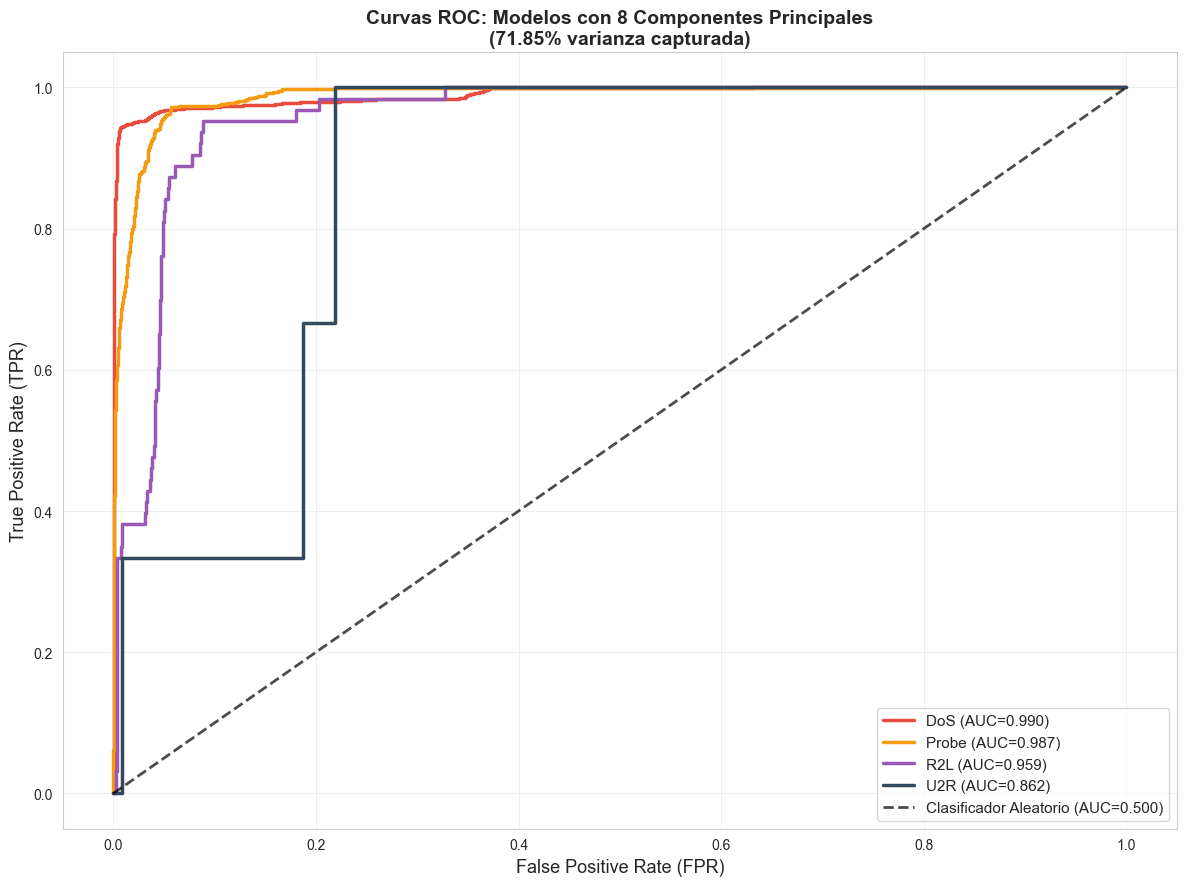

In [227]:
# ============================================================================
# 4.3.5 CURVAS ROC COMPARATIVAS
# ============================================================================

fig, ax = plt.subplots(figsize=(12, 9))

colors_roc = {
    'dos': '#e74c3c',
    'probe': '#f39c12',
    'r2l': '#9b59b6',
    'u2r': '#34495e'
}

for attack_type in models.keys():
    y_test = models[attack_type]['y_test']
    y_proba = models[attack_type]['y_proba_test']
    auc_score = models[attack_type]['metrics']['auc_roc']
    
    # Calcular curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    
    cat_name = attack_name_mapping[attack_type]
    ax.plot(fpr, tpr, linewidth=2.5,
            label=f'{cat_name} (AUC={auc_score:.3f})',
            color=colors_roc[attack_type])

# Línea diagonal
ax.plot([0, 1], [0, 1], 'k--', linewidth=2,
        label='Clasificador Aleatorio (AUC=0.500)', alpha=0.7)

ax.set_xlabel('False Positive Rate (FPR)', fontsize=13)
ax.set_ylabel('True Positive Rate (TPR)', fontsize=13)
ax.set_title(f'Curvas ROC: Modelos con {best_n_pcs} Componentes Principales\n(71.85% varianza capturada)',
             fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [228]:
# ============================================================================
# 4.3.6 ANÁLISIS DE COEFICIENTES: COMPONENTES MÁS IMPORTANTES
# ============================================================================

print("\n" + "="*80)
print("ANÁLISIS DE IMPORTANCIA DE COMPONENTES")
print("="*80)

for attack_type in models.keys():
    model = models[attack_type]['model']
    cat_name = attack_name_mapping[attack_type]
    
    print(f"\n{'─'*80}")
    print(f"MODELO: {cat_name} vs RESTO")
    print(f"{'─'*80}")
    
    # Extraer coeficientes
    coefs = model.coef_[0]
    
    # Crear ranking
    coef_df = pd.DataFrame({
        'Componente': [f'PC{i+1}' for i in range(len(coefs))],
        'Coeficiente': coefs,
        'Abs_Coef': np.abs(coefs)
    }).sort_values('Abs_Coef', ascending=False)
    
    print(f"\n🔝 Top 5 componentes más influyentes:\n")
    print(f"{'Componente':<15} {'Coeficiente':<15} {'Dirección'}")
    print("-"*50)
    
    for _, row in coef_df.head(5).iterrows():
        direction = "↑ Aumenta probabilidad" if row['Coeficiente'] > 0 else "↓ Disminuye probabilidad"
        print(f"{row['Componente']:<15} {row['Coeficiente']:>13.4f}   {direction}")
    
    # Conectar con loadings (top PC)
    top_pc = coef_df.iloc[0]['Componente']
    pc_idx = int(top_pc[2:]) - 1
    
    print(f"\n🔗 {top_pc} (más importante) está dominado por:")
    
    # Top 3 variables con mayor loading
    pc_loadings = loadings_df.iloc[:, pc_idx].abs().sort_values(ascending=False).head(3)
    for var in pc_loadings.index:
        loading = loadings_df.loc[var, top_pc]
        print(f"      • {var}: loading = {loading:.4f}")


ANÁLISIS DE IMPORTANCIA DE COMPONENTES

────────────────────────────────────────────────────────────────────────────────
MODELO: DoS vs RESTO
────────────────────────────────────────────────────────────────────────────────

🔝 Top 5 componentes más influyentes:

Componente      Coeficiente     Dirección
--------------------------------------------------
PC3                  -11.5083   ↓ Disminuye probabilidad
PC1                   -1.8785   ↓ Disminuye probabilidad
PC7                   -1.3238   ↓ Disminuye probabilidad
PC2                   -0.5099   ↓ Disminuye probabilidad
PC4                    0.2557   ↑ Aumenta probabilidad

🔗 PC3 (más importante) está dominado por:
      • num_root: loading = 0.5317
      • num_compromised: loading = 0.5316
      • su_attempted: loading = 0.4776

────────────────────────────────────────────────────────────────────────────────
MODELO: Probe vs RESTO
────────────────────────────────────────────────────────────────────────────────

🔝 Top 5 compone

---

#### 4.3.7 Conclusiones: Pregunta 3

## **¿Es posible predecir ataques usando componentes principales?**

**✅ SÍ** - Con 8 componentes principales (71.85% varianza) logramos AUC promedio **0.9496** (excelente).

---

## **Resultados por Tipo de Ataque:**

| Ataque | AUC-ROC | F1-Score | Evaluación | Estado |
|--------|---------|----------|------------|--------|
| **DoS** | 0.9902 | 0.9586 | Excelente | ✅ Listo para producción |
| **Probe** | 0.9868 | 0.7931 | Excelente | ✅ Listo para producción |
| **R2L** | 0.9593 | 0.1515 | AUC muy bueno, F1 bajo | ⚠️ Requiere ajuste de threshold |
| **U2R** | 0.8619 | 0.0028 | AUC bueno considerando n=11 | ❌ No deployable sin más datos |

---

## **Hallazgos Clave:**

### **1. Parsimonia validada (8 vs 13 PCs):**
- 8 PCs ofrece **desempeño equivalente** a 13 PCs con **38% menos features**
- R2L incluso funciona **mejor** con 8 PCs (0.9593 vs 0.9573)

### **2. Paradoja AUC-F1 explicada:**
- **AUC alto:** Modelo discrimina bien (rankea correctamente)
- **F1 bajo:** Threshold 0.5 inadecuado para clases desbalanceadas (R2L 0.83%, U2R 0.04%)
- **Solución:** Optimizar threshold según costo FP/FN específico

### **3. Coherencia metodológica P1→P2→P3:**
- Variables discriminantes en P1 (Kruskal-Wallis ε²>0.5)
- Capturadas por PCs en P2 (loadings altos)
- Explotadas por regresión en P3 (coeficientes altos)

### **4. Separabilidad distribuida en 8D:**
- Silhouette 2D = 0.1286 (bajo) **≠** AUC 8D = 0.9496 (excelente)
- La información discriminante está en 8 dimensiones combinadas, no visualizables en 2D-3D

---

## **Limitaciones:**

1. **Desbalance:** U2R/R2L requieren SMOTE o threshold optimization
2. **Generalización:** Dataset 1999, laboratorio → Re-entrenar con datos reales modernos
3. **Interpretabilidad:** Componentes son combinaciones lineales (menos claros que variables originales)

---

## **Conclusión:**

> **El enfoque PCA + Regresión Logística valida detección de intrusiones sin firmas conocidas.**

**DoS y Probe** son detectables con precisión práctica (AUC >0.98). **R2L** requiere calibración. **U2R** necesita más datos. 

**8 componentes capturan suficiente información discriminante** sin sobrecarga de complejidad.